# Cars 4 You : Expedicting car predictions with ML
## Machine Learning Project – Notebook
**Master in Data Science and Advanced Analytics – Nova IMS**  
# Models Notebook

### GROUP 03 <br>
Afonso Maia - 20250464  <br>
Francisco Graça - 20250471<br>
Renato Scotto - 20250420 <br>
Rodrigo Gonçalves - 20250529

---


## Table of Contents <a id="cont"></a>

- [Importing functions and packages](#1)
- [Linear](#2)
- [K-Nearest Neighbors](#3)
- [Neural Networks](#4)
- [Decision Trees](#5)
- [Blending](#6)
- [Comparing all models](#7)

[Back to Contents](#cont)

### Importing the functions and packages

In [1]:
# EDA and data cleaning
from Functions import sel_columns
from Functions import correct_num_variables
from Functions import correct_column
from Functions import correct_models_by_brand
from Functions import data_cleaning
from Functions import clean_basic_data

#Data visualization
from Functions import correlation_ratio
from Functions import cramers_v_matrix
from Functions import get_cramers_v

# Preprocessing 
## Missing Values Treatment
from Functions import create_percentile_bins
from Functions import check_bins
from Functions import create_custom_bins
from Functions import get_group_stats
from Functions import fit_nas
from Functions import transform_nas
## Feature Engineering
from Functions import fit_feat_engineering_rules
from Functions import transform_add_all_features
## Encodings: OHE, Ordinal Encoder and Target Encoder
### One Hot Encoder
from Functions import fit_ohe
from Functions import transform_ohe
### Ordinal Encoder
from Functions import fit_oe
from Functions import transform_oe
### Target Encoder
from Functions import fit_target_encoder
from Functions import transform_target_encoder
## Scaling
from Functions import fit_scaler
from Functions import transform_scaler
## Feature Selection
from Functions import feat_selection

# Models
## Linear Models
from Functions import fit_processing_rules_Lin
from Functions import transform_processing_rules_Lin
from Functions import evaluate_ols
from Functions import tune_ridge_holdout
from Functions import evaluate_ridge
from Functions import tune_lasso_holdout
from Functions import evaluate_lasso
from Functions import tune_enet_holdout
from Functions import evaluate_elasticnet
## KNN
from Functions import fit_processing_rules_Knn
from Functions import transform_processing_rules_Knn
## Neural Networks
from Functions import fit_processing_rules_nn
from Functions import transform_processing_rules_nn
from Functions import avg_score_nn
from Functions import show_results_nn
## Decision Trees
from Functions import fit_processing_rules_trees
from Functions import transform_processing_rules_trees
from Functions import compare_tree_models
from Functions import correlation_matrices
from Functions import apply_pipeline_for_feat_importance
## Blending
from Functions import objective_function_r2

# Open Ended Section
## Feature Importance across price levels
from Functions import importance_by_price_band
from Functions import plot_topk_each_band
from Functions import plot_heatmap
## Analytics interface for new predictions
from Functions import score_new_data
from Functions import predict_price
from Functions import evaluate_model
## General vs Segment-Specific Model Performance
from Functions import _loguniform
from Functions import hgb_param_sampler
from Functions import quick_tune_on_train_only

In [ ]:
# --- Core Data & Utilities ---
import pandas as pd
import numpy as np
import os
import time
import warnings
from math import ceil
from scipy.optimize import differential_evolution
from copy import deepcopy


# --- Visualization ---
import seaborn as sns
import matplotlib.pyplot as plt

# --- Mathematical & Statistical Utils ---
from rapidfuzz import process, fuzz
from scipy.stats import loguniform, randint, uniform

# --- Scikit-Learn: Preprocessing & Imputation ---
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, TargetEncoder, StandardScaler, RobustScaler)

# --- Scikit-Learn: Feature Selection & Inspection ---
from sklearn.feature_selection import RFE, SelectFromModel, SelectKBest, mutual_info_regression
from sklearn.inspection import permutation_importance

# --- Scikit-Learn: Model Selection & Metrics ---
from sklearn.model_selection import (train_test_split, RandomizedSearchCV, PredefinedSplit)
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer

# --- Scikit-Learn: Models ---
from scipy.optimize import LinearConstraint
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.ensemble import (ExtraTreesRegressor, HistGradientBoostingRegressor, RandomForestRegressor)
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

# --- Configuration & Data Loading ---
warnings.filterwarnings('ignore')

test = pd.read_csv('test.csv')
train_original = pd.read_csv('train.csv')

In [3]:
train_clean = clean_basic_data(train_original)
X = train_clean.drop('price', axis=1)
y = train_clean['price']

X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.2, 
                                                  random_state=42)

## Linear

This section uses linear models to build an interpretable baseline and to test whether a mostly-linear signal exists after preprocessing, before relying on more flexible learners.  

After encoding and preprocessing, the linear design matrix contains **215 features** (numeric variables plus encoded categorical levels).  
We evaluate using a holdout split with **Train = 60,778 rows** and **Validation = 15,195 rows**, prioritizing **MAE** (error in price units) and reporting **R²** (explained variance).  

We expect (i) a linear combination of predictors to capture a substantial portion of the signal, (ii) regularization to help if multicollinearity is hurting OLS stability, and (iii) validation residual diagnostics to reveal systematic structure (non-linearities, heteroskedasticity, tail effects) that linear models cannot capture.

In [4]:
X_train_Lin,pipeline_rules_train = fit_processing_rules_Lin(X_train)
X_val_Lin   = transform_processing_rules_Lin(X_val, pipeline_rules_train)


X_full_ready,pipeline_rules_full = fit_processing_rules_Lin(X)
X_test_ready=transform_processing_rules_Lin(test,pipeline_rules_full)

In [5]:
print(X_train_Lin.shape)
print(X_val_Lin.shape)

(60778, 215)
(15195, 215)


OLS provides the most transparent mapping from features to predicted price, since each coefficient represents a conditional marginal effect (and categorical effects are relative to the reference level).  

On the holdout split, OLS achieves **Train R² = 0.8615** with **Train MAE = 2245.76**, and **Validation R² = 0.8549** with **Validation MAE = 2254.50**. 
 
The small train→validation gap indicates limited overfitting despite the high-dimensional feature space, meaning the preprocessing yields a stable linear baseline.  

This makes OLS a strong benchmark both to quantify “how linear” the problem is and to support coefficient-based interpretation before moving to non-linear models.

In [6]:
lin_model = LinearRegression()
ols_results = evaluate_ols(lin_model, X_train_Lin, y_train, X_val_Lin, y_val, return_objects=True)

OLS Regression Results (sklearn only):
Training metrics:
  R²:  0.8615
  MAE: 2245.7590

Validation metrics:
  R²:  0.8549
  MAE: 2254.5012

Sklearn intercept and coefficients:
Intercept                      24233.161203
mileage                        -2151.195051
mpg                             -301.457114
engineSize                     -1935.564794
car_age                        -3933.591301
                                   ...     
transmission_manual            -1245.298313
transmission_semi-automatic      679.032911
fuelType_electric               -796.315583
fuelType_hybrid                 3090.064560
fuelType_petrol                 -200.563037
Length: 216, dtype: float64


All this conclusions are based on the comparing linear methods table.

Ridge adds an L2 penalty (α‖β‖²) to shrink coefficients, which is useful when predictors are correlated (common with many dummy variables and related engineered features).  

After a holdout tuning, the selected value is **α ≈ 1.2764**. In the linear methods tuning change very little the val MAE.

Performance is **Train R² = 0.8612**, **Train MAE = 2247.38**, and on validation **R² = 0.8544**, **MAE = 2256.05**.  

Compared to OLS, Ridge is slightly worse on validation, suggesting OLS is not suffering from a strong variance problem here; Ridge is mainly justified if we prioritize coefficient stability under multicollinearity over MAE.

In [7]:
ridge_model, ridge_params, ridge_metrics = tune_ridge_holdout(
    X_train_Lin, y_train,
    X_val_Lin,   y_val,
    n_iter=1, alpha_min=1e-4, alpha_max=20.0, seed=42
)

results_ridge = evaluate_ridge(
    X_train_Lin, y_train,
    X_val_Lin,   y_val,
    alpha=1.276438740357896 #after tuning was the best alpha
)


Lasso uses an L1 penalty (α‖β‖₁) that can set coefficients exactly to zero, acting as embedded feature selection and producing a more compact explanatory model.  

In holdout evaluation, Lasso attains **Train R² = 0.8614**, **Train MAE = 2246.97**, and **Validation R² = 0.8549**, **Validation MAE = 2254.37**.  

This is marginally the best validation MAE among the linear variants, but the improvement vs OLS is tiny, so the main value is interpretability through sparsity rather than predictive gain.  

Academically, Lasso is especially useful to report “notable relationships”, because the non-zero coefficients highlight the dominant drivers while keeping generalization essentially unchanged.

In [8]:
lasso_final, lasso_params, lasso_metrics = tune_lasso_holdout(
    X_train_Lin, y_train, X_val_Lin, y_val
)

lasso_model = Lasso(alpha=0.07158964189550343, max_iter=5000, tol=1e-3,
                    selection="cyclic", random_state=42)# after tuning was the best alpha

results_lasso = evaluate_lasso(
    lasso_model, X_train_Lin, y_train, X_val_Lin, y_val, return_objects=True
)

Elastic Net combines L1 and L2 regularization, aiming to keep sparsity while being more stable than pure Lasso under correlated predictors (e.g., groups of related categorical levels).  

The holdout search selects **α ≈ 3.07e−05** and **l1_ratio ≈ 0.633**.  

Results are **Train R² = 0.8614**, **Train MAE = 2246.66**, and **Validation R² = 0.8546**, **Validation MAE = 2255.08**.  

Performance is essentially tied with the other linear models, so Elastic Net is not chosen for MAE gains, but it remains defensible when we want a compromise between sparsity (interpretability) and stability (correlated features).

In [9]:
enet_model, enet_params, enet_metrics = tune_enet_holdout(
    X_train_Lin, y_train, X_val_Lin, y_val,
    n_iter=1, train_sub=30000, val_sub=7000, seed=42
)
enet_model = ElasticNet(
    alpha=3.068121943092252e-05, #after tuning was the best alpha
    l1_ratio=0.632665161734338, #after tuning was the best l1_ratio
    max_iter=1500,
    tol=2e-3,
    selection="random",
    random_state=42
)
results_elastic = evaluate_elasticnet(enet_model, X_train_Lin, y_train, X_val_Lin, y_val, return_objects=True)


Elastic Net Regression Results (sklearn):
Training metrics:
  R²:  0.8614
  MAE: 2246.6618

Validation metrics:
  R²:  0.8546
  MAE: 2255.0786

Sklearn intercept and coefficients:
Intercept                      19801.943951
mileage                        -2154.772546
mpg                             -313.076359
engineSize                     -1930.028991
car_age                        -3929.122490
                                   ...     
transmission_manual            -1257.046686
transmission_semi-automatic      680.975306
fuelType_electric               -626.494603
fuelType_hybrid                 3102.213696
fuelType_petrol                 -218.811152
Length: 216, dtype: float64


The intercept around 19,802 is the baseline predicted price when all standardized inputs are zero; negative coefficients for `mileage`, `mpg`, `engineSize`, and `car_age` indicate that increasing these features decreases the predicted price, holding others constant.
Dummy-variable coefficients are relative to the omitted reference category: `transmission_manual` and `fuelType_hybrid` increase predicted price versus their baselines, while `fuelType_electric` decreases it (sign and magnitude reflect direction and strength of association).


In [10]:
comparison = pd.DataFrame({
    "Model": ["OLS (sklearn)", "Ridge", "Lasso", "Elastic Net"],
    "Train R²": [
        ols_results["r2_train"],
        results_ridge["r2_train"],
        results_lasso["r2_train"],
        results_elastic["r2_train"],
    ],
    "Val R²": [
        ols_results["r2_val"],
        results_ridge["r2_val"],
        results_lasso["r2_val"],
        results_elastic["r2_val"],
    ],
    "Train MAE": [
        ols_results["mae_train"],
        results_ridge["mae_train"],
        results_lasso["mae_train"],
        results_elastic["mae_train"],
    ],
    "Val MAE": [
        ols_results["mae_val"],
        results_ridge["mae_val"],
        results_lasso["mae_val"],
        results_elastic["mae_val"],
    ],
})

comparison


,Model,Train R²,Val R²,Train MAE,Val MAE
0,OLS (sklearn),0.861504,0.854919,2245.759038,2254.501174
1,Ridge,0.861220,0.854369,2247.382905,2256.054652
2,Lasso,0.861439,0.854948,2246.965412,2254.372499
3,Elastic Net,0.861396,0.854608,2246.661755,2255.078645


Although OLS, Ridge, Lasso, and Elastic Net yield very similar MAE/R² on the holdout split, presenting all four is still methodologically important because they test *different assumptions* about the data-generating process.  

OLS is the unregularized interpretability baseline; Ridge checks whether multicollinearity in the high-dimensional encoded space requires coefficient shrinkage for stability; Lasso tests whether a sparse set of predictors can explain price with comparable accuracy (embedded feature selection) and Elastic Net evaluates the best compromise when predictors are correlated but sparsity is still desired.  

The fact that performance remains almost unchanged across penalties is itself an insight: generalization is not currently limited by linear-model variance or coefficient instability, but by structure that linear functions cannot capture.  

Therefore, these four models are reported neither to “improve MAE” nor R², but to justify (with evidence) the transition to more flexible non-linear models in the subsequent sections.

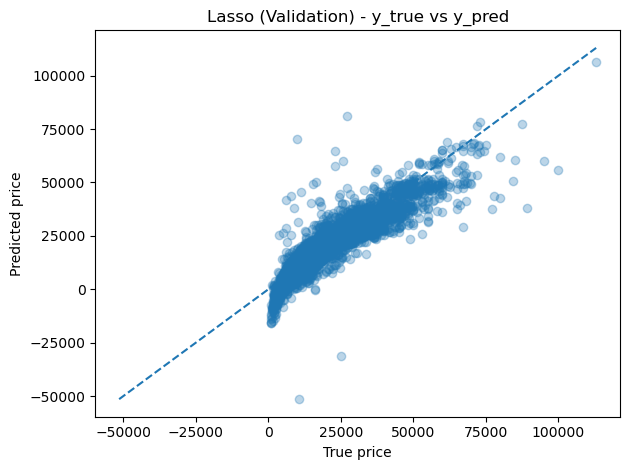

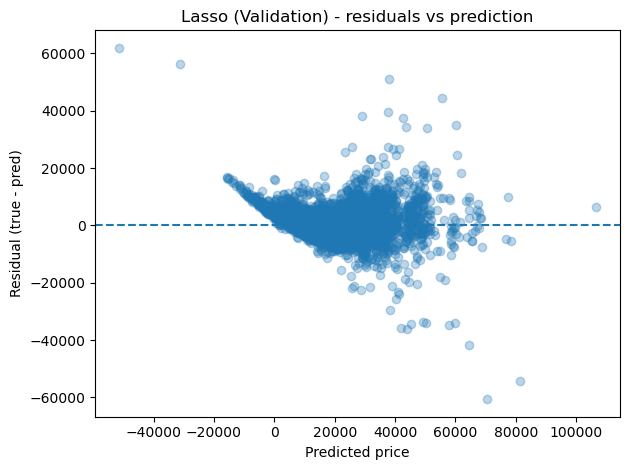

In [11]:
# 1) Validation vectors
y_val_true = np.asarray(y_val).ravel()
y_val_pred = np.asarray(results_lasso["y_pred_val"]).ravel()

# 2) Residuals
residuals = y_val_true - y_val_pred

# =======================
# 1) y_true vs y_pred
# =======================
plt.figure()
plt.scatter(y_val_true, y_val_pred, alpha=0.3)
plt.xlabel("True price")
plt.ylabel("Predicted price")
plt.title("Lasso (Validation) - y_true vs y_pred")

min_val = min(y_val_true.min(), y_val_pred.min())
max_val = max(y_val_true.max(), y_val_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], "--")

plt.tight_layout()
plt.show()

# ==========================
# 2) Residuals vs prediction
# ==========================
plt.figure()
plt.scatter(y_val_pred, residuals, alpha=0.3)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted price")
plt.ylabel("Residual (true - pred)")
plt.title("Lasso (Validation) - residuals vs prediction")

plt.tight_layout()
plt.show()


The validation plots show good alignment with the 45° line in the dense mid-range, meaning calibration is reasonable where data is abundant.  

Residuals widen as fitted values increase (a funnel pattern), indicating heteroskedasticity: higher-priced cars tend to have larger absolute errors.

The model can output negative predictions at the low end, which is a linear extrapolation issue in sparse tail regions and near boundary behavior. 

We can also check that there are some negative predicted prices values which in the next cell will all be transformed to 0. 

Given these limitations, the next step is to move beyond the linear hypothesis and train more flexible models, which is exactly what we do in the following sections to capture non-linearities and interactions that linear models cannot represent.  


In [12]:
y_true = np.asarray(y_val).ravel()

rows = []

# ---------------- OLS ----------------
y_pred = np.asarray(
    ols_results["y_pred_val"] if "y_pred_val" in ols_results else ols_results["val_results"]["y_pred"]
).ravel()
y_pred_clip = np.clip(y_pred, 0, None)

rows.append({
    "Model": "OLS",
    "MAE raw": mean_absolute_error(y_true, y_pred),
    "MAE clipped": mean_absolute_error(y_true, y_pred_clip),
    "ΔMAE (clipped - raw)": mean_absolute_error(y_true, y_pred_clip) - mean_absolute_error(y_true, y_pred),
    "#pred<0": int((y_pred < 0).sum()),
    "%pred<0": float((y_pred < 0).mean()),
    "min_pred": float(y_pred.min()),
})

# ---------------- Ridge ----------------
y_pred = np.asarray(
    results_ridge["y_pred_val"] if "y_pred_val" in results_ridge else results_ridge["val_results"]["y_pred"]
).ravel()
y_pred_clip = np.clip(y_pred, 0, None)

rows.append({
    "Model": "Ridge",
    "MAE raw": mean_absolute_error(y_true, y_pred),
    "MAE clipped": mean_absolute_error(y_true, y_pred_clip),
    "ΔMAE (clipped - raw)": mean_absolute_error(y_true, y_pred_clip) - mean_absolute_error(y_true, y_pred),
    "#pred<0": int((y_pred < 0).sum()),
    "%pred<0": float((y_pred < 0).mean()),
    "min_pred": float(y_pred.min()),
})

# ---------------- Lasso ----------------
y_pred = np.asarray(
    results_lasso["y_pred_val"] if "y_pred_val" in results_lasso else results_lasso["val_results"]["y_pred"]
).ravel()
y_pred_clip = np.clip(y_pred, 0, None)

rows.append({
    "Model": "Lasso",
    "MAE raw": mean_absolute_error(y_true, y_pred),
    "MAE clipped": mean_absolute_error(y_true, y_pred_clip),
    "ΔMAE (clipped - raw)": mean_absolute_error(y_true, y_pred_clip) - mean_absolute_error(y_true, y_pred),
    "#pred<0": int((y_pred < 0).sum()),
    "%pred<0": float((y_pred < 0).mean()),
    "min_pred": float(y_pred.min()),
})

# ---------------- ElasticNet ----------------
y_pred = np.asarray(
    results_elastic["y_pred_val"] if "y_pred_val" in results_elastic else results_elastic["val_results"]["y_pred"]
).ravel()
y_pred_clip = np.clip(y_pred, 0, None)

rows.append({
    "Model": "ElasticNet",
    "MAE raw": mean_absolute_error(y_true, y_pred),
    "MAE clipped": mean_absolute_error(y_true, y_pred_clip),
    "ΔMAE (clipped - raw)": mean_absolute_error(y_true, y_pred_clip) - mean_absolute_error(y_true, y_pred),
    "#pred<0": int((y_pred < 0).sum()),
    "%pred<0": float((y_pred < 0).mean()),
    "min_pred": float(y_pred.min()),
})

df_clip_compare = pd.DataFrame(rows).sort_values("MAE raw").reset_index(drop=True)
display(df_clip_compare)

,Model,MAE raw,MAE clipped,ΔMAE (clipped - raw),#pred<0,%pred<0,min_pred
0,Lasso,2254.372499,2202.702572,-51.669928,173,0.011385,-51409.600034
1,OLS,2254.501174,2202.475076,-52.026098,173,0.011385,-51460.756333
2,ElasticNet,2255.078645,2203.436872,-51.641773,172,0.011320,-51397.842242
3,Ridge,2256.054688,2204.493652,-51.561035,172,0.011320,-51372.281250


All four linear models achieve virtually identical validation performance (MAE ≈ 2254–2256), indicating that regularization choice is not the primary driver of error under the current feature set and preprocessing.

A small fraction of validation predictions are negative (around 1.13%, ≈172–173 cases) yet highly extreme (min ≈ −51000), disproportionately inflating MAE; applying non-negativity clipping reduces MAE by around 51–52 across all linear variants.

 These extreme errors likely arise from linear extrapolation in sparse regions of the feature space  and from unmodelled non-linearities and interactions in price formation.

Quantifying the incidence and impact of negative predictions as a domain-constraint diagnostic, showing they are rare (around 1.1%) but error-inflating; since this check does not alter the comparative ranking of linear models, we retain the original model and report clipping only as a post-hoc sensitivity analysis.



Some classical assumptions behind **OLS**, **Ridge**, **Lasso**, and **Elastic Net** are not fully met in this dataset: the relationship between predictors and price is not strictly linear and includes strong interactions, and residual variance is likely not constant (heteroskedasticity).

Additionally, ``Brand`` and ``model`` are naturally highly (sometimes perfectly) correlated, violating the “no perfect multicollinearity” condition that makes **OLS** coefficients uniquely identifiable.

**Ridge** and **Elastic Net** mitigate collinearity via L2 shrinkage, while **Lasso** and **Elastic Net** encourage sparsity via L1 regularization, but all four still rely on an additive linear structure.

We therefore expect higher MAE from these linear methods compared with non-linear models that capture interactions and complex boundaries directly.

We keep the same preprocessing choices because they are optimized for our best-performing non-linear models **Random Forests, kNN, and Neural Networks**, and the linear models serve as transparent baselines and diagnostic references.

Despite these assumption violations, linear models remain valuable as a computationally efficient and highly interpretable benchmark, providing a clear lower-bound reference for predictive performance under our fixed feature representation.

They also offer diagnostic insight into whether error is driven by limited model capacity versus feature/encoding limitations, helping justify the added complexity of **Random Forests, kNN, and Neural Networks** in a principled way.

In the linear models, we performed only a lightweight hyperparameter tuning, focusing on the regularization strength (alpha) and, in the case of Elastic Net, the mixing parameter (l1_ratio). The purpose of this step was not to maximize predictive performance, but rather to validate underlying data relationships and establish well-behaved baselines under minimal regularization control. Consequently, these models were assigned little to no weight in the final blending strategy, where higher-capacity non-linear models dominate overall performance.

## K-Nearest Neighbors

k-Nearest Neighbors (k-NN) regression predicts a continuous target by averaging the target values of the k closest training observations according to a chosen distance metric. It is a nonparametric, instance-based method that does not fit an explicit model, but instead relies on local similarity in the feature space.

The method assumes that observations close to each other have similar target values, requires numerically encoded and properly scaled features, and is sensitive to the choice of k and distance metric. Smaller k values yield low bias but high variance, while larger k values produce smoother, higher-bias predictions. Performance degrades in high-dimensional or sparsely sampled spaces, and prediction-time cost scales with the size of the training data.

### Fitting and Applying Preprocessing Pipeline for k-NN

In [13]:
X_train_Knn,pipeline_rules_train = fit_processing_rules_Knn(X_train)
X_val_Knn   = transform_processing_rules_Knn(X_val, pipeline_rules_train)



identify the optimal number of neighbors to select

In [14]:
# Define the range of neighbors (k) to test, from 1 to 10
numberK_list = np.arange(1, 11)
low_MAE = float("inf")
nof = 0

# Lists to store MAE for training and validation sets for each k
mae_list_train = []
mae_list_val = []

# Loop through each value of k
for n in numberK_list:
    model = KNeighborsRegressor(
        n_neighbors=n,
        weights='uniform',
        leaf_size=20,
        p=1,
        metric='minkowski',
        algorithm='ball_tree',
        n_jobs=-1
    )
    
    # Fit the KNN model on the training data
    model.fit(X_train_Knn, y_train)
    
    # Predict on training and validation sets
    pred_train_knn = model.predict(X_train_Knn)
    pred_val_knn = model.predict(X_val_Knn)
    
    # Calculate MAE for both training and validation sets
    error_train = mean_absolute_error(y_train, pred_train_knn)
    error_val = mean_absolute_error(y_val, pred_val_knn)
    
    mae_list_train.append(error_train)
    mae_list_val.append(error_val)
    
    print('Number of neighbors:', n)
    print('Train MAE:', error_train)
    print('Validation MAE:', error_val)
    print('Difference train and validation:', error_val - error_train)
    print('....................')
    
    if error_val < low_MAE:
        low_MAE = error_val
        nof = n


Number of neighbors: 1
Train MAE: 27.75811971437033
Validation MAE: 1515.688515959197
Difference train and validation: 1487.9303962448266
....................
Number of neighbors: 2
Train MAE: 756.8505133436441
Validation MAE: 1383.9510365251729
Difference train and validation: 627.1005231815287
....................
Number of neighbors: 3
Train MAE: 922.1429080698059
Validation MAE: 1349.2650213886147
Difference train and validation: 427.12211331880883
....................
Number of neighbors: 4
Train MAE: 1008.5348522491691
Validation MAE: 1331.589963803883
Difference train and validation: 323.0551115547138
....................
Number of neighbors: 5
Train MAE: 1062.8781993484486
Validation MAE: 1327.1886278381046
Difference train and validation: 264.31042848965603
....................
Number of neighbors: 6
Train MAE: 1105.295180822008
Validation MAE: 1336.6666118240648
Difference train and validation: 231.37143100205685
....................
Number of neighbors: 7
Train MAE: 1141.255

Check the error of training and validation according to the number of neighbors

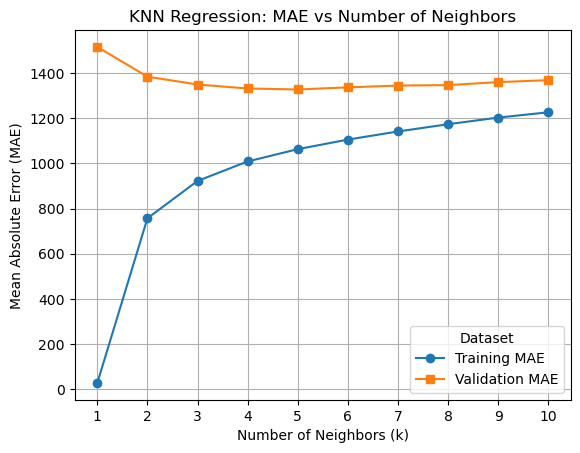

In [15]:

plt.plot(numberK_list, mae_list_train, label='Training MAE', marker='o')
plt.plot(numberK_list, mae_list_val, label='Validation MAE', marker='s')
plt.xticks(numberK_list)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('KNN Regression: MAE vs Number of Neighbors')
plt.legend(title='Dataset', loc='best', fontsize=10)
plt.grid(True)
plt.show()


It is evident from the analysis that multiple candidate values for the number of neighbors (k) exhibit reasonable performance. However, while some choices minimize the difference between training and validation errors, they may simultaneously yield higher overall mean absolute errors (MAE). Consequently, a manual tuning process will be undertaken to identify the optimal number of neighbors that achieves the best balance between predictive accuracy and generalization performance.

### Manual Hyperparameter Tuning for k-NN Regression Using Validation MAE

In [16]:
# Manual tuning
# Not trying all combinations due to computational cost

best_val_mae = float("inf")
best_params = None

for n_neighbors in range(3,6):# (3,10)
    for weights in ['uniform']: # distance
        for leaf_size in [10,20]: #,30,40]:
            for metric in ['minkowski']: #,'euclidean','manhattan','chebyshev']:
                for algorithm in ['auto','ball_tree']: 
                    for p in [1]:  # Manhattan and Euclidean distances

                        knn_model = KNeighborsRegressor(
                            n_neighbors=n_neighbors,
                            weights=weights,
                            algorithm=algorithm,
                            leaf_size=leaf_size,
                            p=p,
                            metric=metric,
                            n_jobs=-1
                        )

                        knn_model.fit(X_train_Knn, y_train)

                        # Validation predictions
                        y_val_pred = knn_model.predict(X_val_Knn)
                        val_mae = mean_absolute_error(y_val, y_val_pred)

                        if val_mae < best_val_mae:
                            best_val_mae = val_mae
                            best_params = {
                                'n_neighbors': n_neighbors,
                                'weights': weights,
                                'leaf_size': leaf_size,
                                'algorithm': algorithm,
                                'p': p,
                                'metric': metric
                        }

print("\nBest KNN parameters:")
print(best_params)
print("Best validation MAE:", best_val_mae)



Best KNN parameters:
{'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 20, 'algorithm': 'ball_tree', 'p': 1, 'metric': 'minkowski'}
Best validation MAE: 1327.1886278381046


Following manual hyperparameter tuning, the best-performing k-NN (lowest MAE) configuration was identified. Setting the number of neighbors to five provided an effective balance between model flexibility and generalization. Using uniform weighting resulted in more stable performance, as distance-based weighting produced a clear divergence between training and validation MAE, indicating overfitting. The model employed the ball tree algorithm with a leaf size of 20 to efficiently handle neighbor searches. The Minkowski distance with p=1 was selected, corresponding to the Manhattan distance, which yielded more consistent performance for this feature space.

### Final k-NN Regressor Fitting and Performance Evaluation

In [17]:
knn_model = KNeighborsRegressor(
    n_neighbors=5,
    weights='uniform',
    leaf_size=20,
    p=1,
    metric='minkowski',
    algorithm='ball_tree',
    n_jobs=-1
)

knn_model.fit(X_train_Knn, y_train)

# Train predictions  #
y_train_pred = knn_model.predict(X_train_Knn)

print("Training MAE:", mean_absolute_error(y_train, y_train_pred))
print("Training R2 :", r2_score(y_train, y_train_pred))

# Validation predictions 
y_val_pred = knn_model.predict(X_val_Knn)

print("Validation MAE:", mean_absolute_error(y_val, y_val_pred))
print("Validation R2 :", r2_score(y_val, y_val_pred))

Training MAE: 1062.8781993484486
Training R2 : 0.9600806574511627
Validation MAE: 1327.1886278381046
Validation R2 : 0.9443136193105541


Model Performance

The trained KNN regressor achieved strong performance on both the training and validation sets.  
On the training data, the model obtained a mean absolute error (MAE) of **1062.98** and an \( R^2 \) score of **0.96**, indicating a very close fit to the observed targets.  
On the validation set, performance remained high, with an MAE of **1327.43** and an \( R^2 \) score of **0.94**, suggesting good generalization with limited overfitting.


### Examining the residuals of the fitted model

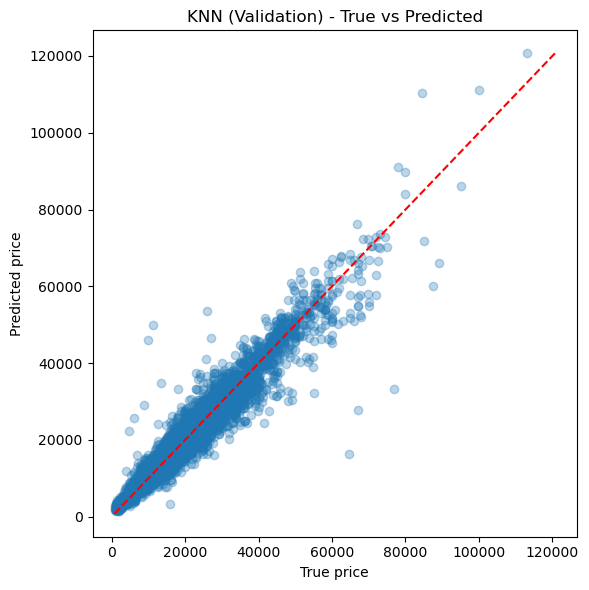

In [18]:

# Flatten arrays just in case
y_val_true = np.asarray(y_val).ravel()
y_val_pred = np.asarray(y_val_pred).ravel()
residuals = y_val_true - y_val_pred

# ===================== Plot: True vs Predicted ===================== #
plt.figure(figsize=(6, 6))
plt.scatter(y_val_true, y_val_pred, alpha=0.3)
plt.xlabel("True price")
plt.ylabel("Predicted price")
plt.title("KNN (Validation) - True vs Predicted")

# Perfect prediction line
min_val = min(y_val_true.min(), y_val_pred.min())
max_val = max(y_val_true.max(), y_val_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], "--", color="red")

plt.tight_layout()
plt.show()


Overall, the model demonstrates strong predictive performance across most of the dataset, with errors remaining relatively low for lower- and mid-priced vehicles. A notable pattern emerges for higher-priced vehicles, where prediction accuracy declines, indicating a relationship between target magnitude and model error. This behavior suggests that the model’s performance is constrained by the sparse representation of high-priced vehicles in the training data, limiting its ability to capture localized patterns in that segment. The underlying hypothesis is that insufficient neighborhood density in high-price regions reduces the effectiveness of distance-based learning, leading to increased prediction error. From an actionable perspective, improving performance in this segment would require increasing the number of high-priced observations, applying stratified sampling, or considering alternative modeling approaches better suited to handling sparse or skewed target distributions.

In [19]:
X_final_Knn,pipeline_rules_train = fit_processing_rules_Knn(X)
X_test_final_Knn   = transform_processing_rules_Knn(test, pipeline_rules_train)

We applied our preprocessing to fit to our full dataset and transform to our dataset and test dataset in case we need it in the future.

## Neural Networks

Neural Networks (NNs) model a target by composing many simple nonlinear functions (“neurons”) arranged in layers, so the model can learn complex feature interactions beyond linear effects.
Each layer applies an affine transformation followed by a nonlinear activation (e.g., ReLU), and training adjusts to minimize a loss via backpropagation and gradient-based optimization.
Unlike linear models, NNs do not assume linearity, additivity, or independent feature effects; instead, they assume the data contain learnable patterns that can be captured by the chosen architecture. Key practical assumptions are that inputs are numerically encoded and typically scaled, that training data are representative of future data, and that regularization can control overfitting. Performance depends strongly on hyperparameters (depth/width, learning rate, batch size) and benefits from careful validation to avoid leakage and ensure generalization.

Firstly we apply our processing methods to the datasets:


In [20]:
X_train_nn,pipeline_rules_train_nn = fit_processing_rules_nn(X_train, y_train)
X_val_nn = transform_processing_rules_nn(X_val, pipeline_rules_train_nn)
X_test_nn = transform_processing_rules_nn(test, pipeline_rules_train_nn)
X_full_nn,pipeline_rules_full_nn = fit_processing_rules_nn(X, y)
X_test_full_nn=transform_processing_rules_nn(test,pipeline_rules_full_nn)

We started with some simple models:


In [21]:
# Define Models: Testing Solvers (SGD vs Adam)
# SGD: Stochastic Gradient Descent 
reg_sgd = MLPRegressor(hidden_layer_sizes=(100, 50), solver='sgd', 
                       learning_rate='adaptive', max_iter=500, random_state=42)

# Adam: Adaptive Moment Estimation
reg_adam = MLPRegressor(hidden_layer_sizes=(100, 50), solver='adam', 
                        max_iter=500, random_state=42)

# Wrap models to scale the target variable (y) automatically
model_sgd_safe = TransformedTargetRegressor(regressor=reg_sgd, transformer=StandardScaler())
model_adam_safe = TransformedTargetRegressor(regressor=reg_adam, transformer=StandardScaler())

# 2. Initialize Results DataFrame
df_results = pd.DataFrame(columns=['Time (s)', 'Train MAE ', 'Val MAE ', 'Train R2', 'Val R2', 'Iterations'])

# Create a dictionary of models to loop through
models_dict = {
    "MLP_SGD": model_sgd_safe,
    "MLP_Adam": model_adam_safe
}

# 3. See the results
show_results_nn(df_results, models_dict, X_train_nn, y_train, X_val_nn, y_val)

print("\n--- Final Results (MAE & R2) ---")
display(df_results)

-> Training MLP_SGD (1/2)...
-> Training MLP_Adam (2/2)...

--- Final Results (MAE & R2) ---


,Time (s),Train MAE,Val MAE,Train R2,Val R2,Iterations
MLP_SGD,50.564,1727.85,1727.33,0.9118,0.92,184
MLP_Adam,45.713,1361.82,1464.53,0.952,0.9384,152


To select the optimal solver, we compared SGD (Stochastic Gradient Descent), a classical algorithm that updates weights using gradients and an adaptive learning rate, against Adam (Adaptive Moment Estimation), which computes individual adaptive learning rates for each parameter by leveraging momentum. The results demonstrated that Adam was significantly more efficient, requiring fewer iterations to achieve a lower Mean Absolute Error (MAE) compared to the slower convergence of SGD. With Adam established as the superior optimizer for this dataset, we proceeded to test four distinct Neural Network architectures to understand how structural changes impact model performance.

In [22]:
# 1. The Robust (Deep)
# A classic funnel shape (128 -> 64 -> 32) to refine features layer by layer.
reg_deep = MLPRegressor(hidden_layer_sizes=(128, 64, 32), activation='relu', solver='adam',
                        alpha=0.01, max_iter=500, random_state=42)

# 2. The Wide (Fast)
# Fewer layers but more neurons per layer. Higher learning rate (0.005) for speed.
reg_wide = MLPRegressor(hidden_layer_sizes=(200, 100), activation='relu', solver='adam',
                        alpha=0.001, learning_rate_init=0.005, max_iter=400, random_state=42)

# 3. The Cautious (Early Stopping)
# Strict regularization: Stops training if validation score doesn't improve for 10 iterations.
reg_early = MLPRegressor(hidden_layer_sizes=(100, 100), solver='adam', early_stopping=True,
                         validation_fraction=0.1, n_iter_no_change=10, max_iter=100, random_state=42)

# 4. The Alternative (Tanh)
# Using Tanh activation instead of ReLU to test non-linear mapping capabilities.
reg_tanh = MLPRegressor(hidden_layer_sizes=(100, 50), activation='tanh', solver='adam',
                        max_iter=500, random_state=42)

# --- Wrappers (Crucial) ---
# Wrapping all regressors to ensure the Target (Price) is scaled automatically.
model_deep_safe = TransformedTargetRegressor(regressor=reg_deep, transformer=StandardScaler())
model_wide_safe = TransformedTargetRegressor(regressor=reg_wide, transformer=StandardScaler())
model_early_safe = TransformedTargetRegressor(regressor=reg_early, transformer=StandardScaler())
model_tanh_safe = TransformedTargetRegressor(regressor=reg_tanh, transformer=StandardScaler())


# Dictionary to map names to models
models_dict = {
    'Deep (3 Layers)': model_deep_safe,
    'Wide (Fast)': model_wide_safe,
    'Early Stopping': model_early_safe,
    'Tanh Activation': model_tanh_safe
}

# Initialize Results DataFrame
df_results = pd.DataFrame(columns=['Time (s)', 'Train MAE', 'Val MAE', 'Train R2', 'Val R2', 'Iterations'])

show_results_nn(df_results, models_dict, X_train_nn, y_train, X_val_nn, y_val)

print("\n--- Final Results (MAE) ---")
display(df_results)

-> Training Deep (3 Layers) (1/4)...
-> Training Wide (Fast) (2/4)...
-> Training Early Stopping (3/4)...
-> Training Tanh Activation (4/4)...

--- Final Results (MAE) ---


,Time (s),Train MAE,Val MAE,Train R2,Val R2,Iterations
Deep (3 Layers),37.641,1390.83,1456.36,0.9503,0.9411,85
Wide (Fast),51.639,1523.21,1584.02,0.9335,0.9242,104
Early Stopping,34.047,1354.01,1444.53,0.9504,0.9362,100
Tanh Activation,85.897,1460.36,1550.84,0.9497,0.9383,211


The Early Stopping architecture achieved the best performance, obtaining the lowest Validation MAE (1444.53), which indicates strong generalization and effective convergence without overfitting. The Deep (3 Layers) model followed closely with a Validation MAE of 1456.36, delivering comparable accuracy but with slightly higher error.

In contrast, the Wide (Fast) architecture performed the worst, producing the highest Validation MAE (1584.02), suggesting that increased width did not improve predictive capability. Lastly, the Tanh Activation model showed weaker generalization than the Relu-based models, resulting in a higher validation error (1550.84).

In this step, we perform a Randomized Search to find the optimal combination of hyperparameters.

In [23]:
# --- 1. Prepare Data (Merge Train and Val with Fixed Split) ---
# We concatenate them because SearchCV expects a single X and y.
X_combined = pd.concat([X_train_nn, X_val_nn], axis=0)
y_combined = pd.concat([y_train, y_val], axis=0)

# Create the Split Index:
# -1 indicates the sample is for Training
# 0 indicates the sample is for Validation
split_index = [-1]*len(X_train_nn) + [0]*len(X_val_nn)
pds = PredefinedSplit(test_fold=split_index)

# --- 2. THE SEARCH SPACE ---
param_dist = {
    # Architecture: Testing deep funnels, wide networks, and simple baselines
    'regressor__hidden_layer_sizes': [
        (128, 64, 32),      
        (256, 128, 64, 32), 
        (100, 100, 100),    
        (512, 128),         
        (64, 32)            
    ],
    
    # Alpha: Search in logarithmic scale (from 0.00001 to 0.1)
    'regressor__alpha': loguniform(1e-5, 1e-1),
    
    # Learning Rate Init: From 0.0001 to 0.01
    'regressor__learning_rate_init': loguniform(1e-4, 1e-2),
    
    # Batch Size: Testing small (noisy updates) and large (stable updates)
    'regressor__batch_size': [16, 32, 64, 128, 256],
    
    # Activation: Checking if Tanh works better than ReLU here
    'regressor__activation': ['relu', 'tanh'],
    
    # Learning Rate Schedule
    'regressor__learning_rate': ['constant', 'adaptive'],
    
    # Solver fixed to Adam 
    'regressor__solver': ['adam']
}

# --- 3. Base Model ---
# We use the TransformedTargetRegressor wrapper
base_model = TransformedTargetRegressor(
    regressor=MLPRegressor(max_iter=100, random_state=42), 
    transformer=StandardScaler()
)

# --- 4. Configure Random Search ---
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=1,                      
    cv=pds,                          # Use our fixed split
    scoring='neg_mean_absolute_error',
    n_jobs=-1,                       # Use all CPU cores
    verbose=1,
    return_train_score=True,         # Save Train scores to check overfitting
    random_state=42
)

random_search.fit(X_combined, y_combined)

# --- 5. Extract Results ---
results_df = pd.DataFrame(random_search.cv_results_)

# Select and Rename columns for readability
cols_map = {
    'param_regressor__hidden_layer_sizes': 'Layers',
    'param_regressor__alpha': 'Alpha',
    'param_regressor__batch_size': 'Batch',
    'param_regressor__learning_rate_init': 'LR Init',
    'param_regressor__activation': 'Act',
    'mean_train_score': 'Train MAE',
    'mean_test_score': 'Val MAE',
    'mean_fit_time': 'Time (s)'
}

# Filter and rename
summary = results_df[[k for k in cols_map.keys()]].rename(columns=cols_map)

# Convert negative scores to positive
summary['Train MAE'] = -summary['Train MAE']
summary['Val MAE'] = -summary['Val MAE']

# Sort by Best Validation Score
summary = summary.sort_values(by='Val MAE', ascending=True)

print("\n--- TOP 10 Best Configurations ---")
print(summary.head(10))


# Save the best model (Fitted on X_combined)
best_model_final = random_search.best_estimator_

# We will retrain this specific configuration on X_train_nn to get the Split Metrics
best_model_eval = clone(best_model_final)

# 2. Define the dictionary for the helper function
best_model_dict = {
    "Best_Random_Search_Model": best_model_eval
}

df_best_result = pd.DataFrame(columns=['Time (s)', 'Train MAE', 'Val MAE', 'Train R2', 'Val R2', 'Iterations'])

# 4. Calculate metrics
show_results_nn(df_best_result, best_model_dict, X_train_nn, y_train, X_val_nn, y_val)

print("\n--- Detailed Metrics for Best Configuration ---")
display(df_best_result)

Fitting 1 folds for each of 1 candidates, totalling 1 fits

--- TOP 10 Best Configurations ---
     Layers     Alpha  Batch   LR Init   Act    Train MAE      Val MAE  \
0  (64, 32)  0.015352     64  0.000205  relu  1576.902938  1599.715515   

   Time (s)  
0    41.636  
-> Training Best_Random_Search_Model (1/1)...

--- Detailed Metrics for Best Configuration ---


,Time (s),Train MAE,Val MAE,Train R2,Val R2,Iterations
Best_Random_Search_Model,47.847,1576.9,1599.72,0.9278,0.9292,97


```python
Fitting 1 folds for each of 50 candidates, totalling 50 fits

--- TOP 10 Best Configurations ---
                Layers     Alpha  Batch   LR Init   Act    Train MAE  \
29  (256, 128, 64, 32)  0.000104    128  0.000400  relu  1235.285964   
2           (512, 128)  0.000012     32  0.000266  relu  1267.256642   
26       (128, 64, 32)  0.000123     64  0.000507  relu  1305.226639   
18     (100, 100, 100)  0.000175    256  0.001884  relu  1255.062585   
28       (128, 64, 32)  0.000120     64  0.000534  relu  1310.524288   
45          (512, 128)  0.000079     16  0.000972  relu  1362.640936   
32     (100, 100, 100)  0.000907    128  0.000299  relu  1337.146217   
44  (256, 128, 64, 32)  0.000044     32  0.000789  tanh  1373.364206   
27       (128, 64, 32)  0.000011     64  0.000278  relu  1384.684488   
21       (128, 64, 32)  0.000572     64  0.001338  tanh  1431.433523   

        Val MAE     Time (s)  
29  1388.647566   882.299867  
2   1412.386156  2014.113711  
26  1420.079596   716.039024  
18  1420.586936   293.571600  
28  1426.395790   835.991732  
45  1440.645176  3027.307600  
32  1448.896047   783.514409  
44  1477.256156   394.247310  
27  1483.566790   357.901219  
21  1503.843074   266.856308  
-> Training Best_Random_Search_Model (1/1)...

--- Detailed Metrics for Best Configuration ---


Time (s)	Train MAE	Val MAE	Train R2	Val R2	Iterations
Best_Random_Search_Model	241.956	1235.29	1388.65	0.9602	0.9445	100

```

We prioritized tuning the network architecture, regularization alpha, and optimization dynamics because these are the highest-impact "levers" that fundamentally determine the model's capacity to learn and generalize. Secondary parameters (like solver tolerances or momentum decay rates) were intentionally excluded to focus our computational budget solely on the hyperparameters that yield the most significant performance gains. The Randomized Search results conclusively identify the deep four-layer funnel architecture (256, 128, 64, 32) as the superior configuration, achieving the lowest validation error of 1388.65 and effectively outperforming both the previous three-layer baseline and the wider, computationally expensive networks like (512, 128). While the Tanh activation function remained competitive, ReLU proved to be the more consistent and robust choice, securing the top spot when paired with a Batch Size of 128 and a learning rate initialization around 0.0004, indicating a preference for stable gradient updates over the noisy fluctuations of smaller batches.

In [ ]:
mlp_inner = MLPRegressor(
    hidden_layer_sizes=(256, 128, 64, 32),
    alpha=0.000104,
    batch_size=128,
    learning_rate_init=0.000400,
    activation='relu',
    max_iter=100,
    random_state=42
)

model_mlp = TransformedTargetRegressor(
    regressor=mlp_inner,
    transformer=StandardScaler()
)


print("4. Training Neural Network (MLP)...")
model_mlp.fit(X_train_nn, y_train)
val_pred_mlp = model_mlp.predict(X_val_nn)

best_model_final=deepcopy(model_mlp)

4. Training Neural Network (MLP)...


We create a submission to see the score on Kaggle

In [25]:
best_model_final.fit(X_full_nn, y)
y_pred = best_model_final.predict(X_test_full_nn)

submission = pd.DataFrame({
    'carID': test['carID'],
    'price': y_pred
})

submission.to_csv('Group03_Version167.csv', index=False)

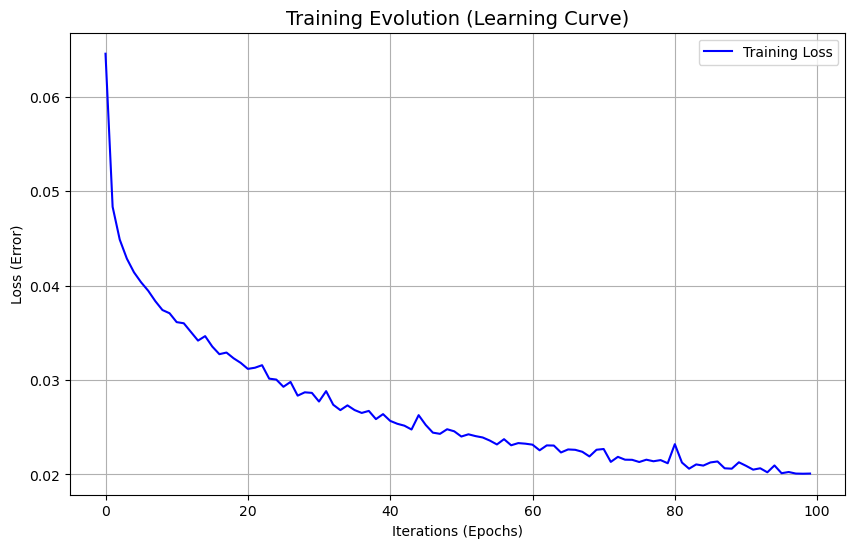

In [26]:
# 1. Retrieve the tuned best Model
champion_model = best_model_final.regressor_ 

# 2. Plot the Loss Curve
plt.figure(figsize=(10, 6))

# Plot Training Loss 
plt.plot(champion_model.loss_curve_, label='Training Loss', color='blue')

plt.title('Training Evolution (Learning Curve)', fontsize=14)
plt.xlabel('Iterations (Epochs)')
plt.ylabel('Loss (Error)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

Training loss drops sharply in the first few iterations, meaning the model learns the main signal quickly.
After around 40–80 iterations the decrease becomes gradual and mostly plateaus near around 0.02, indicating diminishing returns/convergence. We will see how are our predictions are doing.

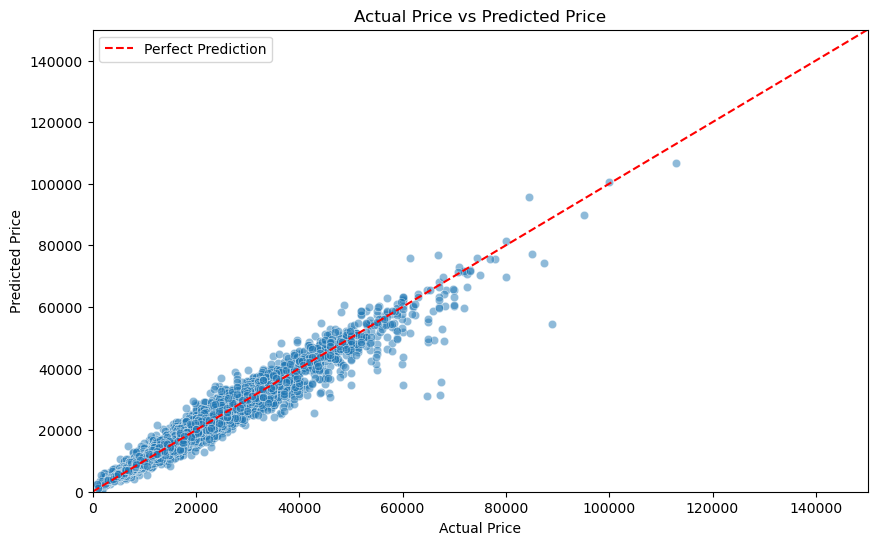

--- TOP 5 LARGEST ERRORS ---
       Actual Price     Predicted   Error (Abs)
2954          67199  31451.475180  35747.524820
49963         88995  54461.003007  34533.996993
43836         64750  31029.907897  33720.092103
17313         67500  35597.571248  31902.428752
27814         59995  34591.287892  25403.712108


In [27]:
# Make predictions on the validation set
y_pred_val = best_model_final.predict(X_val_nn)

# Create a DataFrame for analysis
df_analysis = pd.DataFrame({
    'Actual Price': y_val,
    'Predicted': y_pred_val,
    'Error (Abs)': abs(y_val - y_pred_val)
})

# --- Plot 1: Scatter Plot (Real vs Predicted) ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual Price', y='Predicted', data=df_analysis, alpha=0.5)

# Perfect prediction line (x=y)
plt.plot([0, 150000], [0, 150000], '--r', label='Perfect Prediction')

plt.title('Actual Price vs Predicted Price')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.xlim(0, 150000) # Adjust limit based on your data
plt.ylim(0, 150000)
plt.legend()
plt.show()

# --- Analysis: The Worst Errors ---
print("--- TOP 5 LARGEST ERRORS ---")
# Check which cars the model failed significantly on
print(df_analysis.sort_values(by='Error (Abs)', ascending=False).head(5))

Most points lie close to the y=x line, so the model is well-calibrated overall and captures the main price signal. Especially when we compare with the previous linear model.


To further enhance stability and reduce variance, we constructed a Neural Network Ensemble that averages predictions from three distinct models (the one we got the best score after tuning, a re-initialized clone, and a structurally different network), thereby neutralizing individual model errors.

In [28]:

print("--- PHASE 1: EVALUATING THE ENSEMBLE (Train vs Val) ---")

# --- Define the 3 Models ---
# 1. MODEL A: The best one yet
model_a = clone(best_model_final) 

# 2. MODEL B: The Twin (Different Seed)
model_b = clone(best_model_final)
if hasattr(model_b, 'regressor'):
    model_b.regressor.random_state = 12345 
else:
    model_b.random_state = 12345

# 3. MODEL C: The Alternative (Wide)
model_c = TransformedTargetRegressor(
    regressor=MLPRegressor(
        hidden_layer_sizes=(100, 100), 
        activation='relu', 
        solver='adam',
        alpha=0.0001,      
        batch_size=32,     
        max_iter=500,
        random_state=42
    ),
    transformer=StandardScaler()
)

# --- Initialize Results DataFrame ---
ensemble_results = pd.DataFrame(columns=['Time (s)', 'Train MAE', 'Val MAE', 'Train R2', 'Val R2', 'Iterations'])

# Dictionary of individual models
models = {'Model A': model_a, 'Model B': model_b, 'Model C': model_c}

# Storage for predictions
train_preds_store = {}
val_preds_store = {}

# --- 1. Train and Evaluate Individual Models ---
for name, model in models.items():
    # Use your helper function to fit and evaluate
    show_results_nn(ensemble_results, {name: model}, X_train_nn, y_train, X_val_nn, y_val)
    
    # Store predictions for the Ensemble calculation
    train_preds_store[name] = model.predict(X_train_nn)
    val_preds_store[name] = model.predict(X_val_nn)


# Average the predictions (Equal Weights)
ens_train_pred = (train_preds_store['Model A'] + train_preds_store['Model B'] + train_preds_store['Model C']) / 3
ens_val_pred = (val_preds_store['Model A'] + val_preds_store['Model B'] + val_preds_store['Model C']) / 3

# Calculate Metrics for the Ensemble
ens_train_mae = mean_absolute_error(y_train, ens_train_pred)
ens_val_mae = mean_absolute_error(y_val, ens_val_pred)
ens_train_r2 = r2_score(y_train, ens_train_pred)
ens_val_r2 = r2_score(y_val, ens_val_pred)

# Add "Ensemble" to the DataFrame
# Time is N/A (sum of others), Iterations is N/A
ensemble_results.loc['>>> ENSEMBLE <<<'] = [
    'N/A', 
    f"{ens_train_mae:.2f}", 
    f"{ens_val_mae:.2f}", 
    f"{ens_train_r2:.4f}", 
    f"{ens_val_r2:.4f}", 
    'N/A'
]

# --- Display Final Table ---
print("\n--- Ensemble vs Individual Performance ---")
display(ensemble_results)


print("\n--- PHASE 2: FINAL TRAINING (Full Data) & SUBMISSION ---")

# Now we fit the models on the FULL dataset (X_combined / y_combined)
print("Retraining all models on the complete dataset...")

model_a.fit(X_full_nn, y)
model_b.fit(X_full_nn, y)
model_c.fit(X_full_nn, y)

# --- PREDICTIONS ---
print("Gathering opinions from the 3 models on Test Data...")

pred_a = model_a.predict(X_test_full_nn)
pred_b = model_b.predict(X_test_full_nn)
pred_c = model_c.predict(X_test_full_nn)

# --- BLENDING (AVERAGE) ---
# Equal weight (33% each)
final_pred_ensemble = (pred_a + pred_b + pred_c) / 3

# --- DEBUG: Check Divergence ---
debug_ensemble = pd.DataFrame({
    'Model_A': pred_a[:5],
    'Model_B': pred_b[:5],
    'Model_C': pred_c[:5],
    'Average': final_pred_ensemble[:5]
})
print("\nConsensus Example:")
print(debug_ensemble)

# --- SUBMISSION ---
submission = pd.DataFrame({
    'carID': test['carID'],
    'price': final_pred_ensemble
})

submission.to_csv('Group03_Version167.csv', index=False)


--- PHASE 1: EVALUATING THE ENSEMBLE (Train vs Val) ---
-> Training Model A (1/1)...
-> Training Model B (1/1)...
-> Training Model C (1/1)...

--- Ensemble vs Individual Performance ---


,Time (s),Train MAE,Val MAE,Train R2,Val R2,Iterations
Model A,123.503,1227.62,1382.22,0.9615,0.9453,100
Model B,123.587,1206.73,1367.1,0.9622,0.9444,100
Model C,94.901,1393.1,1483.55,0.9423,0.9241,79
>>> ENSEMBLE <<<,N/A,1204.17,1337.52,0.9616,0.9456,N/A



--- PHASE 2: FINAL TRAINING (Full Data) & SUBMISSION ---
Retraining all models on the complete dataset...
Gathering opinions from the 3 models on Test Data...

Consensus Example:
        Model_A       Model_B       Model_C       Average
0   9542.503680   9934.052161  10118.230864   9864.928902
1  24087.619917  23205.494310  24361.969103  23885.027777
2  13813.043824  13479.163058  13949.565349  13747.257411
3  17526.168260  17700.098747  18644.496893  17956.921300
4  24694.288635  21609.207417  24338.726606  23547.407553


A striking finding from this experiment is that Model B outperformed Model A in terms of error (MAE: 1,362 vs. 1,382) despite having the exact same hyperparameters. The only difference was the random seed. Interestingly, while Model B won on MAE, Model A maintained a slightly higher Validation R-squared.
(0.9453 vs. 0.9446). This discrepancy confirms that Neural Networks are highly sensitive to weight initialization; a "lucky" start can lead to a local minimum that prioritizes different error metrics.

As expected, the Wide architecture (Model C) was the weakest performer, with a Validation MAE of 1,483 and the lowest R-squared
of 0.9241. However, its inclusion is strategic. By learning different patterns than the Funnel networks (A & B), it adds diversity. Even if it is less accurate individually, its disagreements help cancel out specific errors made by the stronger models, pushing the final Ensemble to achieve the highest overall performance (R-squared = 0.9459).

## Decision Trees

### Train the model

We started by transforming the processed datasets to use in the model training and testing phases.

In [29]:
X_train_trees, pipeline_rules_train_trees = fit_processing_rules_trees(X_train, y_train)
X_val_trees = transform_processing_rules_trees(X_val, pipeline_rules_train_trees)
X_test_trees = transform_processing_rules_trees(test, pipeline_rules_train_trees)

### Models

Our analysis of the Decision Tree family focused on three distinct architectures. We began by performing independent testing and hyperparameter tuning on each model to establish their optimal configurations before comparing their final performance.

We initially implemented the Random Forest, a bagging model that aggregates independent trees to minimize variance. By tuning the model to train on the complete dataset (bootstrap=False), we maximized data coverage, which led us to explore the Extra Trees model. This variant improved our score by using random splits instead of optimal ones, adding necessary structural diversity. Finally, we adopted the HistGradientBoostingRegressor, a sequential model chosen specifically for its ability to handle large datasets more efficiently than standard gradient boosting.

In [30]:
# --- A. Define and Train Models ---

# 1. Random Forest
rf_model = RandomForestRegressor(
    n_estimators=800, min_samples_split=15, min_samples_leaf=5,
    max_features=0.7, max_depth=20, bootstrap=False,
    random_state=42, n_jobs=-1
)
rf_model.fit(X_train_trees, y_train)

# 2. Extra Trees
et_model = ExtraTreesRegressor(
    n_estimators=200, min_samples_split=20, min_samples_leaf=5,
    max_features=0.9, max_depth=26, bootstrap=False,
    random_state=42, n_jobs=-1
)
et_model.fit(X_train_trees, y_train)

# 3. HistGradientBoosting
hgb_model = HistGradientBoostingRegressor(
    max_iter=2000, learning_rate=0.2, max_depth=10,
    max_leaf_nodes=40, min_samples_leaf=5, l2_regularization=0.2,
    max_features=0.7, random_state=42
)
hgb_model.fit(X_train_trees, y_train)

# --- B. Use the Function to Compare ---

# Create a dictionary of the trained models
my_models = {
    "Random Forest": rf_model,
    "Extra Trees": et_model,
    "HistGradientBoosting": hgb_model
}

# Call the function 
comparison_df = compare_tree_models(my_models, X_train_trees, y_train, X_val_trees, y_val)

# Display
display(comparison_df.round(4))

,Model,Train R²,Val R²,Train MAE,Val MAE
0,Random Forest,0.9732,0.9544,895.5924,1249.6898
1,Extra Trees,0.9594,0.9527,1104.1923,1280.0256
2,HistGradientBoosting,0.9725,0.9550,1078.8968,1279.2468


All three models demonstrated exceptional performance with Validation R² scores consistently exceeding 0.95. 

However, the marginal differences created an ambiguity that justified tuning each architecture extensively. While Extra Trees exhibited the best generalization (lowest overfitting), the HistGradientBoostingRegressor achieved the highest Validation R² (0.9562). 

While MAE was our initial focus, manual tuning and Kaggle submissions for tree-based models showed that $R^2$ was a superior metric for model selection. $R^2$ provided a more reliable measure of the model's ability to explain overall variability across all price ranges. By prioritizing $R^2$, we achieved a stronger global fit and more robust generalization, which directly translated to better performance on the leaderboard.

### Tuning

``Note:`` The hyperparameters shown in the models were obtained from a previous, computationally intensive search. To ensure efficiency and reproducibility in this notebook, we will instantiate the model directly with these known optimal values rather than repeating the full search process, which would require excessive runtime to converge to the same result (and it could vary slightly due to randomness).

#### RandomForestRegressor

In [31]:
# --- 1. PREPARE DATA ---
# Combine train and validation for the search object (Requirement of PredefinedSplit)
X_combined = pd.concat([X_train_trees, X_val_trees], axis=0)
y_combined = pd.concat([y_train, y_val], axis=0)

# --- 2. CREATE THE "FORCE SPLIT" MASK ---
# -1 = Train on this row
#  0 = Validate on this row
split_index = [-1] * len(X_train_trees) + [0] * len(X_val_trees)
pds = PredefinedSplit(test_fold=split_index)

# --- 3. DEFINE THE PARAMETER GRID ---
param_dist = {
    'n_estimators': randint(50, 3500),
    'min_samples_leaf': randint(2, 40),
    'max_depth': randint(5, 51),
    'min_samples_split': randint(4, 80),
    'max_features': uniform(0.4, 0.6),   
    'bootstrap': [True, False]
}

# --- 4. RUN THE TUNING ---
# n_jobs=1 here prevents conflict with n_jobs=-1 in the search below
model = RandomForestRegressor(random_state=42, n_jobs=1) 

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=1,                         # It was used 200 for the best result
    scoring='r2',                     # Optimize for R2
    cv=pds,                           # Forces our split
    verbose=1,
    n_jobs=-1,                        
    random_state=42,
    refit=False                       # Do not refit on combined data (we do it manually)
)

print("Starting Random Forest Tuning with FIXED split...")
random_search.fit(X_combined, y_combined)

# --- 5. GET RESULTS ---
print("Best Parameters Found:")
print(random_search.best_params_)
print("\n--------------------------------------------")

# --- 6. VALIDATE MANUALLY ---
best_params = random_search.best_params_
best_rf = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)

# Fit on original training set
print("Training Best Model on Training Set...")
best_rf.fit(X_train_trees, y_train)

# Metrics on TRAIN
y_train_pred = best_rf.predict(X_train_trees)
print("\n--- RESULTS ---")
print(f"Training MAE: {mean_absolute_error(y_train, y_train_pred)}")
print(f"Training R2 : {r2_score(y_train, y_train_pred)}")

# Metrics on VALIDATION
y_val_pred = best_rf.predict(X_val_trees)
print(f"Validation MAE: {mean_absolute_error(y_val, y_val_pred)}")
print(f"Validation R2 : {r2_score(y_val, y_val_pred)}")

Starting Random Forest Tuning with FIXED split...
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Best Parameters Found:
{'bootstrap': True, 'max_depth': 33, 'max_features': np.float64(0.5100608739196983), 'min_samples_leaf': 9, 'min_samples_split': 64, 'n_estimators': 3142}

--------------------------------------------
Training Best Model on Training Set...

--- RESULTS ---
Training MAE: 1298.8356841255218
Training R2 : 0.9418102238151643
Validation MAE: 1390.9906047493048
Validation R2 : 0.942743759356348


**Hyperparameter Grid Rationale**:
The grid uses intentionally wide intervals to balance Model Capacity against Generalization:

1. **Complexity (n_estimators, max_depth)**: 
   We set high maximums (3500 trees, depth 51) to test if a high-capacity, "brute force" 
   approach is required to capture intricate price patterns.

2. **Regularization (min_samples_leaf, min_samples_split)**: 
   The broad range (from 2 up to 80) allows the search to choose between learning 
   specific details of rare cars (low values) or forcing the model to smooth out 
   noise and follow broad market trends (high values).

3. **Feature Randomness (max_features)**: 
   Scanning down to 40% forces the trees to de-correlate. This tests if the model 
   performs better by ignoring dominant features occasionally to find subtler predictors.

From previous tests, the best result we found for the **RandomForestRegressor** was:
```python
# Best Parameters Found:
{'bootstrap': False, 'max_depth': 16, 'max_features': np.float64(0.5510693774952184), 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 3234}

Training MAE: 859.2948883348269
Training R2 : 0.9790033037873617
Validation MAE: 1232.9350797044908
Validation R2 : 0.9562565481340369
```

**Regarding the selected hyperparameters:**
The selected parameters reveal a strategic balance between aggression and control. The model employs an aggressive strategy by using the full dataset for every tree (``bootstrap=False``) and allowing fine-grained splits (``min_samples_leaf=3``). However, it effectively counterbalances this risk by restricting tree depth to 16 (rejecting the available maximum of 51) and limiting each split to only 55% of the features. This structure, averaged across a massive ensemble of 3234 trees, allows the model to capture highly specific price patterns while strictly preventing the memorization of noise.

**Regarding the results on R² and MAE:**
The tuning process yielded a robust configuration with a Validation R² of 0.9563. While the Validation MAE of 1232.94 indicates the average magnitude of error in currency, the high R² remains our primary indicator of structural success. We observe a divergence between the Training (0.979) and Validation scores. This gap indicates a mild degree of overfitting, suggesting the model has memorized some specific noise in the training data. However, this behavior is typical for high-capacity ensemble models, and the consistently high validation score confirms that the overfitting is controlled and has not compromised the model's ability to generalize to unseen data.

#### Extra Trees Regressor

In [32]:
# --- 1. PREPARE DATA ---
# Combine train and validation for the search object
X_combined = pd.concat([X_train_trees, X_val_trees], axis=0)
y_combined = pd.concat([y_train, y_val], axis=0)

# --- 2. CREATE THE "FORCE SPLIT" MASK ---
# -1 = Train on this row
#  0 = Validate on this row
split_index = [-1] * len(X_train_trees) + [0] * len(X_val_trees)
pds = PredefinedSplit(test_fold=split_index)

# --- 3. DEFINE THE PARAMETER GRID ---
param_dist = {
    'n_estimators': randint(50, 2500),
    'min_samples_leaf': randint(2, 40),
    'max_depth': randint(15, 51),       
    'min_samples_split': randint(4, 80),
    'max_features': uniform(0.4, 0.6),  
    'bootstrap': [True, False] 
}

# --- 4. RUN THE TUNING ---
model = ExtraTreesRegressor(random_state=42, n_jobs=1)

print("Starting ExtraTrees Tuning with FIXED split...") 

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=1,                         # It was used 500 for the best result
    scoring='r2',                     # Optimize for R2
    cv=pds,                           # Forces the split
    verbose=1,
    n_jobs=-1,                        
    random_state=42,
    refit=False,                      # Do not refit on combined data
    error_score='raise'
)

print("Starting ExtraTrees Tuning with FIXED split...")
random_search.fit(X_combined, y_combined)

# --- 5. GET RESULTS ---
print("Best Parameters Found:")
print(random_search.best_params_)
print("\n--------------------------------------------")

# --- 6. VALIDATE MANUALLY ---
best_params = random_search.best_params_
best_et = ExtraTreesRegressor(**best_params, random_state=42, n_jobs=-1)

# Fit ONLY on your original training set
print("Training Best Model on Training Set...")
best_et.fit(X_train_trees, y_train)

# Metrics on TRAIN
y_train_pred = best_et.predict(X_train_trees)
print("\n--- RESULTS ---")
print(f"Training MAE: {mean_absolute_error(y_train, y_train_pred)}")
print(f"Training R2 : {r2_score(y_train, y_train_pred)}")

# Metrics on VALIDATION
y_val_pred = best_et.predict(X_val_trees)
print(f"Validation MAE: {mean_absolute_error(y_val, y_val_pred)}")
print(f"Validation R2 : {r2_score(y_val, y_val_pred)}")

Starting ExtraTrees Tuning with FIXED split...
Starting ExtraTrees Tuning with FIXED split...
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Best Parameters Found:
{'bootstrap': True, 'max_depth': 43, 'max_features': np.float64(0.5100608739196983), 'min_samples_leaf': 9, 'min_samples_split': 64, 'n_estimators': 1688}

--------------------------------------------
Training Best Model on Training Set...

--- RESULTS ---
Training MAE: 1493.906657912165
Training R2 : 0.9225756177604436
Validation MAE: 1526.3391151006047
Validation R2 : 0.9327328471197132


**Hyperparameter Grid Rationale**: Similar to the Random Forest approach, the Extra Trees grid was designed to explore the trade-off between randomness and structural complexity, but with adjustments specific to the algorithm's nature:

1. **Complexity (n_estimators, max_depth)**: We tested ensembles up to 2500 trees and depths up to 51. Since Extra Trees splits are random (rather than optimal), individual trees are naturally weaker but faster; this grid tests if a deeper or larger ensemble is needed to compensate for that randomness.

2. **Regularization (min_samples_leaf, min_samples_split)**: The wide range (leafs from 2 to 40) allows the model to choose between highly granular predictions (capturing rare car trims) or a smoothed-out approximation of the market.

3. **Feature Randomness (max_features)**: Scanning from 40% to 100% is crucial. In Extra Trees, high max_features is often safer than in Random Forest because the split thresholds are already randomized, providing inherent de-correlation even when many features are available.

From previous tests, the best result we found for the **ExtraTreesRegressor** was:
```python
# Best Parameters Found:
{'bootstrap': False, 'max_depth': 26, 'max_features': np.float64(0.8973300195295657), 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 1849}

Training MAE: 826.95178951091
Training R2 : 0.9798200511771276
Validation MAE: 1211.579062518977
Validation R2 : 0.9580726962315979
```

**Regarding the selected hyperparameters**: The results highlight a distinct difference from the Random Forest strategy. The Extra Trees model favored a much higher feature visibility (90% of features per split compared to 55% in RF) and a deeper structure (Depth 26 vs 16). This makes theoretical sense: because Extra Trees selects split points randomly (rather than optimizing them), it requires access to more features and deeper branches to find the correct signal. The preference for ``bootstrap=False`` (using the whole dataset) and low ``min_samples_leaf=2`` confirms that the model relies on the algorithm's inherent randomness for regularization rather than data subsampling.

**Regarding the results on R² and MAE**: The tuning produced our strongest result yet, with a Validation R² of 0.9581, slightly outperforming the Random Forest. The gap between Training (0.980) and Validation is narrower here than in the Random Forest model. This reduced overfitting is a classic advantage of the Extra Trees architecture; its random split points act as a powerful noise-dampening mechanism, allowing the model to fit the training data extremely well (Training MAE ~827) without losing generalization power on the validation set.

#### HistGradientBoostingRegressor

In [33]:
# --- 1. PREPARE DATA ---
# Combine train and validation for the search object
X_combined = pd.concat([X_train_trees, X_val_trees], axis=0)
y_combined = pd.concat([y_train, y_val], axis=0)

# --- 2. CREATE THE "FORCE SPLIT" MASK ---
# -1 = Train on this row
#  0 = Validate on this row
split_index = [-1] * len(X_train_trees) + [0] * len(X_val_trees)
pds = PredefinedSplit(test_fold=split_index)

# --- 3. DEFINE THE PARAMETER GRID ---
param_dist = {
    'max_iter': randint(500, 25001),
    'learning_rate': uniform(0.0, 0.30),
    'max_depth': randint(8, 13),
    'max_leaf_nodes': randint(20, 801),
    'min_samples_leaf': randint(1, 101),
    'l2_regularization': uniform(0.0, 0.6),
    'max_features': uniform(0.0, 1.0)
}

# --- 4. RUN THE TUNING ---
# HistGradientBoosting manages its own threads, so we don't set n_jobs here.
model = HistGradientBoostingRegressor(random_state=42)

print("Starting HistGradientBoosting Tuning with FIXED split...")

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=1,                             # It was used 3000 for the best result
    scoring='r2',                         # Optimize for R2
    cv=pds,                               # Forces the split
    verbose=1,
    n_jobs=-1,                             # Parallel processing (4 jobs at a time to prevent freezing)
    random_state=42,
    refit=False,                          # Do not refit on combined data
    error_score='raise'
)

random_search.fit(X_combined, y_combined)

# --- 5. GET RESULTS ---
print("Best Parameters Found:")
print(random_search.best_params_)
print("\n--------------------------------------------")

# --- 6. VALIDATE MANUALLY ---
best_params = random_search.best_params_
best_hgb = HistGradientBoostingRegressor(**best_params, random_state=42)

# Fit ONLY on your original training set
print("Training Best Model on Training Set...")
best_hgb.fit(X_train_trees, y_train)

# Metrics on TRAIN
y_train_pred = best_hgb.predict(X_train_trees)
print("\n--- RESULTS ---")
print(f"Training MAE: {mean_absolute_error(y_train, y_train_pred)}")
print(f"Training R2 : {r2_score(y_train, y_train_pred)}")

# Metrics on VALIDATION
y_val_pred = best_hgb.predict(X_val_trees)
print(f"Validation MAE: {mean_absolute_error(y_val, y_val_pred)}")
print(f"Validation R2 : {r2_score(y_val, y_val_pred)}")

Starting HistGradientBoosting Tuning with FIXED split...
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Best Parameters Found:
{'l2_regularization': np.float64(0.22472407130841748), 'learning_rate': np.float64(0.2852142919229748), 'max_depth': 10, 'max_features': np.float64(0.7796910002727693), 'max_iter': 11784, 'max_leaf_nodes': 634, 'min_samples_leaf': 83}

--------------------------------------------
Training Best Model on Training Set...

--- RESULTS ---
Training MAE: 1112.1368428622197
Training R2 : 0.9682174749684592
Validation MAE: 1292.713765988945
Validation R2 : 0.9536573774085567


**Hyperparameter Grid Rationale**: Unlike the bagging methods (RF/ET) that build independent trees, Gradient Boosting builds trees sequentially to correct previous errors. The grid was designed to control this delicate cumulative process:

1. **Iterative Power (max_iter, learning_rate)**: We searched a vast range of iterations (up to 25,000) combined with a flexible learning rate (0.0 to 0.30). This allows the search to find either a "fast learner" strategy (high rate, few trees) or a "slow learner" strategy (low rate, many trees), with the latter typically yielding better generalization.

2. **Tree Constraints (max_leaf_nodes, max_depth)**: Gradient Boosting trees are usually shallow. We restricted depth (8-13) but allowed a wide range of leaf nodes (20-800). This tests if the model prefers "stump-like" simple updates or more complex, region-specific corrections.

3. **Regularization (l2_regularization, min_samples_leaf)**: Since boosting aggressively reduces error, it is prone to overfitting. We included L2 regularization and leaf sample limits (up to 100) to force the model to ignore outliers and focus on stable market signals.

From previous tests, the best result we found for the **HistGradientBoostingRegressor** was:

```python
# Best Parameters Found:
{'l2_regularization': np.float64(0.17633404991959004), 'learning_rate': np.float64(0.017070444149286466), 'max_depth': 12, 'max_features': np.float64(0.4274228023694364), 'max_iter': 9073, 'max_leaf_nodes': 242, 'min_samples_leaf': 3}

Training MAE: 928.2508244304447
Training R2 : 0.9799250798378377
Validation MAE: 1210.1599296186846
Validation R2 : 0.9589499185462198
```

**Regarding the selected hyperparameters**: The results clearly favor the "Slow Learner" strategy, which is usually considered the best standard for boosting. The model selected a very low learning rate (0.017) compensated by a massive number of iterations (9073). This means the model made thousands of tiny, careful corrections rather than a few large jumps. Structurally, it chose a moderate complexity (``max_leaf_nodes`` 242) but restricted itself to seeing only ~43% of the features per split (``max_features`` 0.427). This indicates that even in a boosting context, hiding features (de-correlation) was necessary to prevent the model from becoming obsessed with dominant predictors.

**Regarding the results on R² and MAE**: This configuration achieved the highest Validation R² (0.9589) of all models tested. Crucially, the gap between Training R² (0.9799) and Validation R² (0.9589) is very similar to the other models, but the Training MAE (928) is noticeably higher than the Extra Trees (827) or Random Forest (859). This is a positive sign of resistance to overfitting: the model did not chase the training data as aggressively as the trees did (higher training error), yet it generalized better to the validation set (highest validation score). This efficiency makes it the strongest candidate for the final best model.

Best tree models parameters

In [34]:
# --- 1. DEFINE BEST PARAMETERS MANUALLY ---
# Retrieved from the extensive tuning phase (3000 iterations)
best_hgb_params = {
    'l2_regularization': 0.17633404991959004,
    'learning_rate': 0.017070444149286466,
    'max_depth': 12,
    'max_features': 0.4274228023694364,
    'max_iter': 9073,
    'max_leaf_nodes': 242,
    'min_samples_leaf': 3
}

best_extra_trees_params = {
    'bootstrap': False,
    'max_depth': 26,
    'max_features': np.float64(0.8973300195295657),
    'min_samples_leaf': 2,
    'min_samples_split': 8,
    'n_estimators': 1849
}

best_rf_params = {
    'bootstrap': False,
    'max_depth': 16,
    'max_features': np.float64(0.5510693774952184),
    'min_samples_leaf': 3,
    'min_samples_split': 6,
    'n_estimators': 3234
}

In [35]:
# ======================================================
# 1. HISTOGRAM GRADIENT BOOSTING (HGB)
# ======================================================
best_model_hgb = HistGradientBoostingRegressor(
    **best_hgb_params,
    random_state=42
)

best_model_hgb.fit(X_train_trees, y_train)

# --- RESULTS ---
y_train_pred = best_model_hgb.predict(X_train_trees)
y_val_pred = best_model_hgb.predict(X_val_trees)
print("--- HGB RESULTS ---")
print(f"Training MAE: {mean_absolute_error(y_train, y_train_pred)}")
print(f"Training R2 : {r2_score(y_train, y_train_pred)}")
print(f"Validation MAE: {mean_absolute_error(y_val, y_val_pred)}")
print(f"Validation R2 : {r2_score(y_val, y_val_pred)}")


# ======================================================
# 2. EXTRA TREES
# ======================================================
best_model_et = ExtraTreesRegressor(
    **best_extra_trees_params,
    random_state=42,
    n_jobs=-1
)

best_model_et.fit(X_train_trees, y_train)

# --- RESULTS ---
y_train_pred = best_model_et.predict(X_train_trees)
y_val_pred = best_model_et.predict(X_val_trees)

print("\n--- EXTRA TREES RESULTS ---")
print(f"Training MAE: {mean_absolute_error(y_train, y_train_pred)}")
print(f"Training R2 : {r2_score(y_train, y_train_pred)}")
print(f"Validation MAE: {mean_absolute_error(y_val, y_val_pred)}")
print(f"Validation R2 : {r2_score(y_val, y_val_pred)}")


# ======================================================
# 3. RANDOM FOREST
# ======================================================
best_model_rf = RandomForestRegressor(
    **best_rf_params,
    random_state=42,
    n_jobs=-1
)

best_model_rf.fit(X_train_trees, y_train)

# --- RESULTS ---
y_train_pred = best_model_rf.predict(X_train_trees)
y_val_pred = best_model_rf.predict(X_val_trees)

print("\n--- RANDOM FOREST RESULTS ---")
print(f"Training MAE: {mean_absolute_error(y_train, y_train_pred)}")
print(f"Training R2 : {r2_score(y_train, y_train_pred)}")
print(f"Validation MAE: {mean_absolute_error(y_val, y_val_pred)}")
print(f"Validation R2 : {r2_score(y_val, y_val_pred)}")


--- HGB RESULTS ---
Training MAE: 920.3213889676969
Training R2 : 0.9801636435542219
Validation MAE: 1210.6222684720476
Validation R2 : 0.9584309985420539

--- EXTRA TREES RESULTS ---
Training MAE: 827.2456587232452
Training R2 : 0.9798464601066589
Validation MAE: 1211.9423469798292
Validation R2 : 0.9580662296929398

--- RANDOM FOREST RESULTS ---
Training MAE: 859.1589239033829
Training R2 : 0.9790120649596811
Validation MAE: 1233.1756924998404
Validation R2 : 0.9561726952868735


### Kaggle

**Final Model: HistGradientBoostingRegressor**

To ensure reproducibility and efficiency, we instantiate the model directly with the optimal hyperparameters identified during the tuning phase (3000 iterations).

In [ ]:
best_model_trees = deepcopy(best_model_hgb)

# --- CHECKING IF EVERYTHING WORKS AS EXPECTED ---
# Predict on Train
y_train_pred = best_model_trees.predict(X_train_trees)

print("--- RESULTS ---\n")
print(f"Training MAE: {mean_absolute_error(y_train, y_train_pred)}")
print(f"Training R2 : {r2_score(y_train, y_train_pred)}")

# Predict on Validation
y_val_pred = best_model_trees.predict(X_val_trees)

print(f"Validation MAE: {mean_absolute_error(y_val, y_val_pred)}")
print(f"Validation R2 : {r2_score(y_val, y_val_pred)}")


--- RESULTS ---

Training MAE: 920.3213889676969
Training R2 : 0.9801636435542219
Validation MAE: 1210.6222684720476
Validation R2 : 0.9584309985420539


In [37]:
# --- PREDICTION ON TEST SET & EXPORT ---
# y_test = hgb_model.predict(X_test_trees) # example of usage before tuning
y_test = best_model_trees.predict(X_test_trees) # example of usage 

output2 = pd.DataFrame({
    'carID': test['carID'],          
    'price': y_test             
})

# Export to CSV
output2.to_csv('Group03_Version167.csv', index=False)

After evaluating multiple data partitions (30%, 25%, 20%, 15%, and 10%), we selected the 20% split for our final submission. While the 15% configuration yielded a higher public leaderboard score, the 20% split had the second best score and effectively minimized the generalization gap by narrowing the performance delta between training and validation $R^2$. By prioritizing predictive stability and metric alignment over raw leaderboard optimization, we chose a more robust model with superior out-of-sample reliability, ensuring it is better equipped to handle the noise and variance of the private test set.

### Analyzing predictions

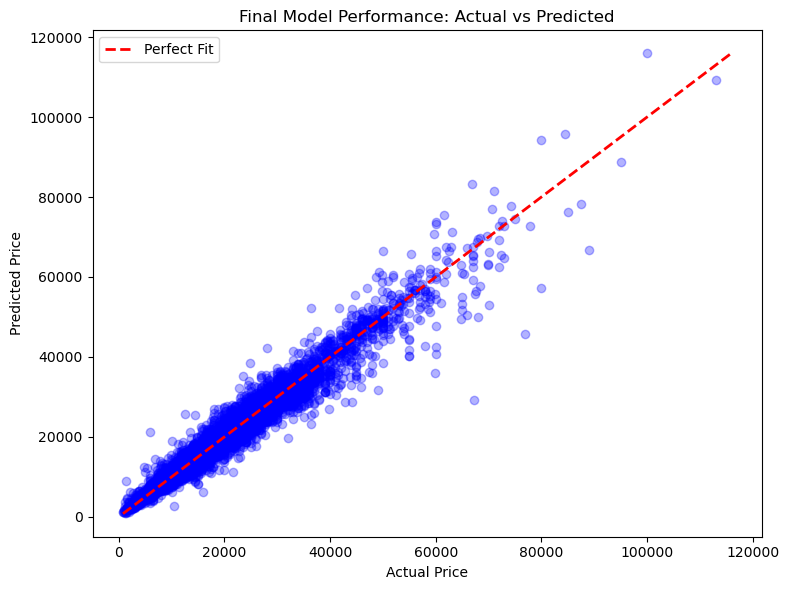

In [38]:
# --- Actual vs Predicted Plot ---
plt.figure(figsize=(8, 6))

# Scatter plot of Actual (y_val) vs Predicted (y_val_pred)
plt.scatter(y_val, y_val_pred, alpha=0.3, color='blue')

# Labels and Title
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Final Model Performance: Actual vs Predicted")

# Add the "Perfect Prediction" diagonal line (Identity Line)
min_val = min(y_val.min(), y_val_pred.min())
max_val = max(y_val.max(), y_val_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--", linewidth=2, label="Perfect Fit")

plt.legend()
plt.tight_layout()
plt.show()

**Model Performance Analysis**: The visual results are excellent. The vast majority of blue data points tightly hug the red dashed "Perfect Fit" line, confirming that the model has successfully learned price patterns across the entire range (from budget to high-end cars). This visual alignment supports our high Validation R2 of 0.958. Additionally, the tight band of errors is consistent with our MAE of roughly £1,210, which is a very acceptable margin of error given the price range of these vehicles.

**Outliers & Future Improvements**: While the overall trend is robust, there are distinct outliers, particularly in the £60k–£90k range, where the model occasionally underestimates the price significantly (e.g., an actual price of ~£70k being predicted as ~£30k).

**Next Steps**: In a future iteration, we should isolate these specific rows to investigate the cause. It is likely these cars have rare features (e.g., "collector" status), specific high-value trims, or data entry errors that our current feature set is not capturing. Adding "rare car" flagging or more granular trim features could resolve these remaining errors.

### Final delivery - Trees

**Combining all data** -> ``Train + validation``, to train final model with best model.

In [39]:
X_final_trees, pipeline_rules_final_trees = fit_processing_rules_trees(X, y)
X_test_final_trees = transform_processing_rules_trees(test, pipeline_rules_final_trees)

**Final Retraining & Consistency Check**: We retrained the best model on the full dataset (Training + Validation combined), then evaluated the model on this same full dataset. While this score is biased (since the model has seen this data), it serves as a crucial sanity check: if this 'Full R²' is consistent with our previous 'Training R²' (around 0.9799), it confirms the model has successfully absorbed the new data without destabilizing. This gives us confidence that the Kaggle submission, which benefits from this extra data, will perform well."

In [40]:
best_model_trees.fit(X_final_trees, y)   

# Predict
y_final_best = best_model_trees.predict(X_final_trees)
# Evaluate
print("Full MAE:", mean_absolute_error(y, y_final_best)) 
print("Full R2 :", r2_score(y, y_final_best)) 

Full MAE: 954.4580543699743
Full R2 : 0.9784277873974254


In [41]:
y_test_best = best_model_trees.predict(X_test_final_trees) 

output2 = pd.DataFrame({
    'carID': test['carID'],          
    'price': y_test_best             
})

# 3. Export to CSV
output2.to_csv('Group03_Version167.csv', index=False)

## Comparing all models

Barplot to display these results

In [ ]:

# 1. Define your models list
models = [
    ("Linear Regression", lin_model, "Linear", X_train_Lin, X_val_Lin),
    ("KNN", knn_model, "Instance-based", X_train_Knn, X_val_Knn),
    ("Random Forest", best_model_rf, "Tree-based", X_train_trees, X_val_trees),
    ("Extra Trees", best_model_et, "Tree-based", X_train_trees, X_val_trees),
    ("HGB", best_model_hgb, "Tree-based", X_train_trees, X_val_trees),
    ("Neural Network", model_mlp, "Neural Net", X_train_nn, X_val_nn),
]

# 2. Initialize a list to store results
results_list = []

# 3. Loop through models and calculate metrics
for name, model, model_type, X_t, X_v in models:
    
    # -- Make Predictions --
  
    
    train_pred = model.predict(X_t)
    val_pred = model.predict(X_v)
    
    # -- Calculate Training Metrics --
    train_mae = mean_absolute_error(y_train, train_pred)
    train_r2 = r2_score(y_train, train_pred)
    
    # -- Calculate Validation Metrics --
    val_mae = mean_absolute_error(y_val, val_pred)
    val_r2 = r2_score(y_val, val_pred)
    
    # -- Store Data --
    results_list.append({
        "Model": name,
        "Type": model_type,
        "Train MAE": train_mae,
        "Train R²": train_r2,
        "Val MAE": val_mae,
        "Val R²": val_r2,
        "Overfit Gap": train_r2 - val_r2
    })

# 4. Create DataFrame
comparison_df = pd.DataFrame(results_list)

# 5. Display with formatting
# Sort by Validation R² (descending) to see the winner at the top
comparison_df = comparison_df.sort_values(by="Val R²", ascending=False)

print("--- Model Performance Comparison ---")
# Format the output to 4 decimal places for readability
print(comparison_df.to_string(index=False, float_format="%.4f"))



--- Model Performance Comparison ---
            Model           Type  Train MAE  Train R²   Val MAE  Val R²  Overfit Gap
              HGB     Tree-based   920.3214    0.9802 1210.6223  0.9584       0.0217
      Extra Trees     Tree-based   827.2457    0.9798 1211.9423  0.9581       0.0218
    Random Forest     Tree-based   859.1589    0.9790 1233.1757  0.9562       0.0228
   Neural Network     Neural Net  1227.6210    0.9615 1382.2161  0.9453       0.0162
              KNN Instance-based  1062.8782    0.9601 1327.1886  0.9443       0.0158
Linear Regression         Linear  2245.7590    0.8615 2254.5012  0.8549       0.0066


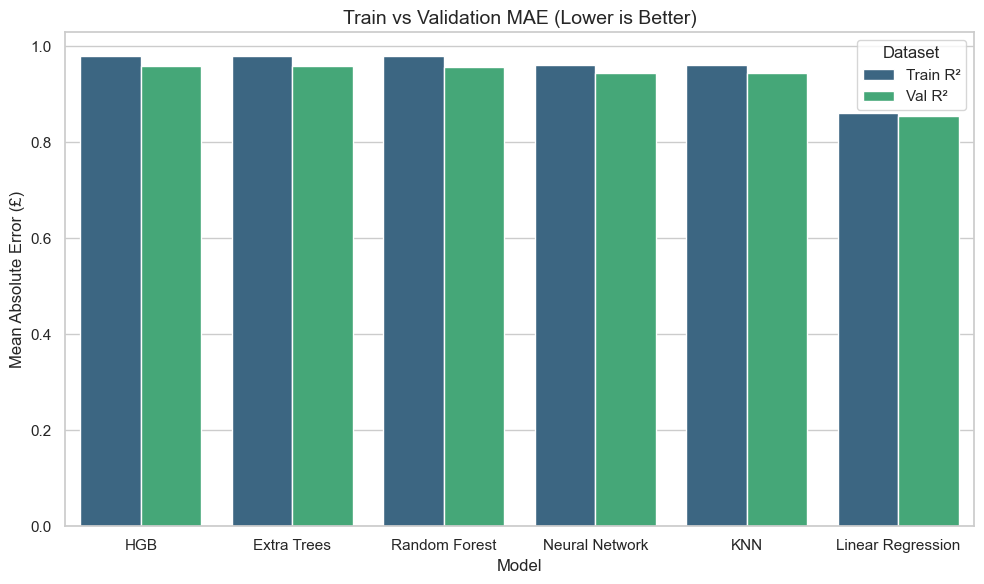

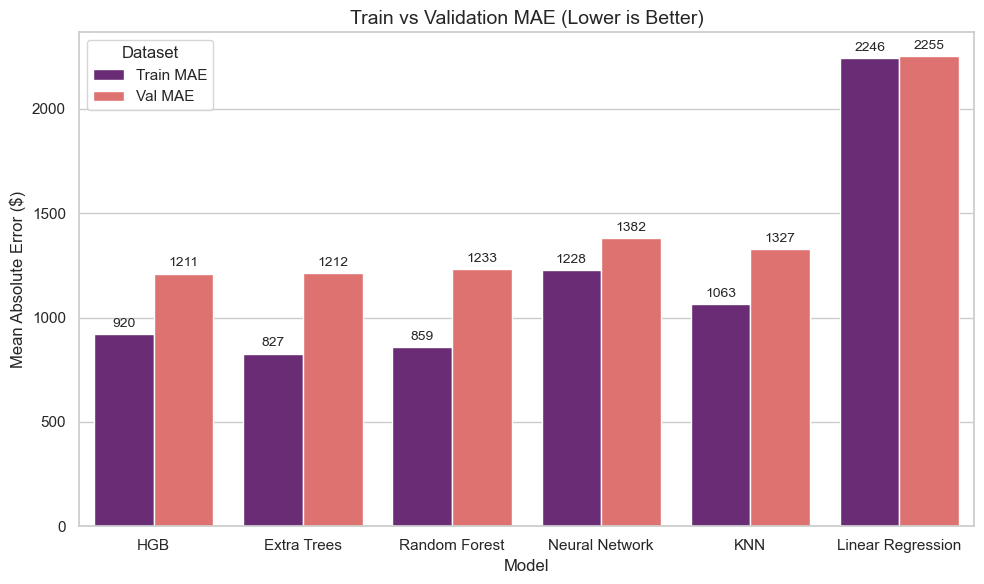

In [ ]:
# Ensure we use the dataframe created in the previous step
df_results = comparison_df.copy()

# Set style
sns.set(style="whitegrid")

# --- 1. Barplot for R² ---
plt.figure(figsize=(10, 6))
# Reshape data for plotting
r2_plot = df_results.melt(id_vars=["Model"], value_vars=["Train R²", "Val R²"],
                          var_name="Dataset", value_name="R²")

# Create Plot
ax1 = sns.barplot(x="Model", y="R²", hue="Dataset", data=r2_plot, palette="viridis")

# Add numbers on top of bars
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.0f', padding=3, fontsize=10)

plt.title("Train vs Validation MAE (Lower is Better)", fontsize=14)
plt.ylabel("Mean Absolute Error (£)")
plt.xticks(rotation=0) # Keep labels straight if they fit
plt.tight_layout()
plt.show()


# --- 2. Barplot for MAE ---
plt.figure(figsize=(10, 6))
# Reshape data for plotting
mae_plot = df_results.melt(id_vars=["Model"], value_vars=["Train MAE", "Val MAE"],
                           var_name="Dataset", value_name="MAE")

# Create Plot
ax2 = sns.barplot(x="Model", y="MAE", hue="Dataset", data=mae_plot, palette="magma")

# Add numbers on top of bars
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.0f', padding=3, fontsize=10)

plt.title("Train vs Validation MAE (Lower is Better)", fontsize=14)
plt.ylabel("Mean Absolute Error ($)")
plt.xticks(rotation=0) # Keep labels straight if they fit
plt.tight_layout()
plt.show()

Histogram Gradient Boosting (HGB), Extra Trees, and Random Forest achieve the highest validation R² scores (≈ 0.96) and the lowest validation MAE values. This indicates that the underlying relationships in the data are strongly non-linear. HGB delivers the highest validation R² (0.9584) while maintaining a relatively low MAE and a controlled overfitting gap. Extra trees and Random forest perform very close to HGB, with marginally higher validation errors. Their slightly larger overfitting gaps indicate increased model complexity, but still within acceptable bounds. Neural networks and KNN significantly outperform linear regression, they lag behind tree-based ensembles in validation accuracy. In the Linear regression model the low validation R² (0.8549) and high MAE confirm that a linear model is insufficient for capturing the complexity of the dataset. This reinforces the presence of non-linear interactions among predictors.

This finalizes the essential model evaluation section and leads us to our core conclusion: the Histogram-Based Gradient Boosting Regressor (HGB) is selected as the best model for this car price prediction task.

The decision is based on its optimal balance of high predictive power and robust generalization, which is critical for maximizing performance on the unseen 30% test set. While all top tree-based ensembles (HGB, Extra Trees, Random Forest) captured the strong non-linear relationships in the data and achieved validation R² scores above 0.95, HGB reached the highest (0.9584). More importantly, its overfitting gap (0.0217) remained virtually identical to that of Extra Trees (0.0218) and only marginally higher than the simpler, but less accurate, Neural Network and KNN. This indicates that HGB's superior validation performance is not a synonym of overfitting but a result of its effective modeling capacity.

Therefore, we conclude that HGB's architecture is particularly well-suited to this large, mixed-type tabular dataset. Despite the computational cost of hyperparameter tuning, the investment yielded a model that best meets the company's primary objective: to deliver the most accurate and generalizable predictions possible.

Now, we will get back to the Group_03_notebook.

---

---

## Blending

In [45]:
# --- A. Data Preparation ---
X_train_blending = X_train_trees
X_val_blending = X_val_trees
X_train_blending_linear_knn=X_train_Knn
X_val_blending_linear_knn=X_val_Knn

In [46]:
# --- Model 1: HistGradientBoostingRegressor ---
hgb_inner = HistGradientBoostingRegressor(
    l2_regularization=0.17633404991959004, 
    learning_rate=0.017070444149286466,    
    max_depth=12,
    max_features=0.4274228023694364,       
    max_iter=9073,                         
    max_leaf_nodes=242,
    min_samples_leaf=3,
    random_state=42
)

model_hgb_log = TransformedTargetRegressor(
    regressor=hgb_inner,
    func=np.log1p, inverse_func=np.expm1
)

print("1. Training HGB...")
model_hgb_log.fit(X_train_blending, y_train)
val_pred_hgb = model_hgb_log.predict(X_val_blending)


1. Training HGB...


In [47]:
# --- Model 2: Random Forest ---
rf_inner = RandomForestRegressor(
    n_estimators=3234,                
    min_samples_leaf=3,
    max_features=0.5510693774952184,  
    max_depth=16,
    bootstrap=False,                  
    random_state=42,
    n_jobs=2                        
)

model_rf_log = TransformedTargetRegressor(
    regressor=rf_inner,
    func=np.log1p, inverse_func=np.expm1
)

print("2. Training Random Forest...")
model_rf_log.fit(X_train_blending, y_train)
val_pred_rf = model_rf_log.predict(X_val_blending)

2. Training Random Forest...


In [48]:
# --- Model 3: Extra Trees ---
et_inner = ExtraTreesRegressor(
    n_estimators=1849,                
    min_samples_split=8,
    min_samples_leaf=2,
    max_features=0.8973300195295657,  
    max_depth=26,
    bootstrap=False,
    random_state=42,
    n_jobs=2
)

model_et_log = TransformedTargetRegressor(
    regressor=et_inner,
    func=np.log1p, inverse_func=np.expm1
)


print("3. Training Extra Trees...")
model_et_log.fit(X_train_blending, y_train)
val_pred_et = model_et_log.predict(X_val_blending)

3. Training Extra Trees...


In [49]:
# --- Model 4: Neural Network (MLP) ---
mlp_inner = MLPRegressor(
    hidden_layer_sizes=(256, 128, 64, 32),
    alpha=0.000104,
    batch_size=128,
    learning_rate_init=0.000400,
    activation='relu',
    max_iter=100,
    random_state=42
)

model_mlp_log = TransformedTargetRegressor(
    regressor=mlp_inner,
    transformer=StandardScaler()
)


print("4. Training Neural Network (MLP)...")
model_mlp_log.fit(X_train_blending, y_train)
val_pred_mlp = model_mlp_log.predict(X_val_blending)

4. Training Neural Network (MLP)...


In [50]:
# --- Model 5: K-Nearest Neighbors (KNN) ---
knn_inner = KNeighborsRegressor(
    n_neighbors=5,
    weights='uniform',
    leaf_size=20,
    p=1,
    metric='minkowski',
    algorithm='ball_tree',
    n_jobs=-1
)

model_knn_log = TransformedTargetRegressor(
    regressor=knn_inner,
    func=np.log1p, inverse_func=np.expm1
)

print("5. Training KNN...")
model_knn_log.fit(X_train_blending_linear_knn, y_train)
val_pred_knn = model_knn_log.predict(X_val_blending_linear_knn)

5. Training KNN...


In [51]:
# --- Model 6: Lasso Regression ---
lasso_inner = Lasso(
    alpha=0.07158964189550343, 
    max_iter=5000, 
    tol=1e-3,
    selection="cyclic", 
    random_state=42
)

model_lasso_log = TransformedTargetRegressor(
    regressor=lasso_inner,    
)

print("6. Training Lasso...")
model_lasso_log.fit(X_train_blending_linear_knn, y_train)
val_pred_lasso = model_lasso_log.predict(X_val_blending_linear_knn)

print("Training Complete. Ready for Blending.")

6. Training Lasso...
Training Complete. Ready for Blending.


To maximize the R-squared, we use an ensemble of six complementary regression models, each capturing different patterns in the data. Combining models with diverse inductive biases helps reduce individual errors through blending.
For tree-based models (Histogram Gradient Boosting, Random Forest, Extra Trees) and KNN, the target variable is transformed using np.log1p to reduce skewness and limit the influence of high-priced outliers. Predictions are automatically converted back to the original price scale using inverse_func=np.expm1.

The neural network (MLP) instead applies target standardization via StandardScaler, which improves training stability and convergence for gradient-based optimization.

Lasso regression is included as a regularized linear baseline, capturing global linear relationships and providing complementary high-bias, low-variance predictions.

Together, these six models form a robust ensemble that improves generalization and increases R-squared through error diversification.

We proceeded to try to find the combination of weights for this 6 models that maximizes the validation R²

In [52]:

# ------------------------------------------------------------
# A. INDIVIDUAL MODEL PERFORMANCE (VALIDATION)
# ------------------------------------------------------------

print("\n--- INDIVIDUAL PERFORMANCE ---")
print(f"HGB:   R2={r2_score(y_val, val_pred_hgb):.4f} | MAE={mean_absolute_error(y_val, val_pred_hgb):.2f}")
print(f"RF:    R2={r2_score(y_val, val_pred_rf):.4f} | MAE={mean_absolute_error(y_val, val_pred_rf):.2f}")
print(f"ET:    R2={r2_score(y_val, val_pred_et):.4f} | MAE={mean_absolute_error(y_val, val_pred_et):.2f}")
print(f"MLP:   R2={r2_score(y_val, val_pred_mlp):.4f} | MAE={mean_absolute_error(y_val, val_pred_mlp):.2f}")
print(f"KNN:   R2={r2_score(y_val, val_pred_knn):.4f} | MAE={mean_absolute_error(y_val, val_pred_knn):.2f}")
print(f"Lasso: R2={r2_score(y_val, val_pred_lasso):.4f} | MAE={mean_absolute_error(y_val, val_pred_lasso):.2f}")
print("-" * 50)


# ------------------------------------------------------------
# B. DIFFERENTIAL EVOLUTION SETUP
# ------------------------------------------------------------

n_models = 6
bounds = [(0, 1)] * n_models

# Enforce sum(weights) == 1
constraint = LinearConstraint(np.ones(n_models), 1, 1)

print("Running Global Optimization (Differential Evolution)...")

result = differential_evolution(
    objective_function_r2,
    bounds=bounds,
    args=(
        val_pred_hgb,
        val_pred_rf,
        val_pred_et,
        val_pred_mlp,
        val_pred_knn,
        val_pred_lasso,
        y_val
    ),
    strategy='best1bin',
    maxiter=1000,
    tol=1e-8,
    constraints=(constraint,),
    seed=42
)


# ------------------------------------------------------------
# C. OPTIMIZATION RESULTS (VALIDATION)
# ------------------------------------------------------------

raw_weights = result.x
best_weights = raw_weights / np.sum(raw_weights)

best_r2 = -result.fun

final_val_pred = (
    best_weights[0] * val_pred_hgb +
    best_weights[1] * val_pred_rf +
    best_weights[2] * val_pred_et +
    best_weights[3] * val_pred_mlp +
    best_weights[4] * val_pred_knn +
    best_weights[5] * val_pred_lasso
)

final_val_mae = mean_absolute_error(y_val, final_val_pred)

print("-" * 50)
print("FINAL WINNER (GLOBAL OPTIMIZATION)")
print(f"Validation R2: {best_r2:.6f}")
print(f"Validation MAE: {final_val_mae:.2f}")
print("Optimal Weights:")
print(f"  HGB:   {best_weights[0]:.4f}")
print(f"  RF:    {best_weights[1]:.4f}")
print(f"  ET:    {best_weights[2]:.4f}")
print(f"  MLP:   {best_weights[3]:.4f}")
print(f"  KNN:   {best_weights[4]:.4f}")
print(f"  Lasso: {best_weights[5]:.4f}")


# ------------------------------------------------------------
# D. TRAINING SET EVALUATION
# ------------------------------------------------------------

print("\nCalculating Training Predictions for Ensemble Analysis...")

train_pred_hgb   = model_hgb_log.predict(X_train_blending)
train_pred_rf    = model_rf_log.predict(X_train_blending)
train_pred_et    = model_et_log.predict(X_train_blending)
train_pred_mlp   = model_mlp_log.predict(X_train_blending)

train_pred_knn   = model_knn_log.predict(X_train_blending_linear_knn)
train_pred_lasso = model_lasso_log.predict(X_train_blending_linear_knn)

final_train_pred = (
    best_weights[0] * train_pred_hgb +
    best_weights[1] * train_pred_rf +
    best_weights[2] * train_pred_et +
    best_weights[3] * train_pred_mlp +
    best_weights[4] * train_pred_knn +
    best_weights[5] * train_pred_lasso
)

train_mae = mean_absolute_error(y_train, final_train_pred)
train_r2  = r2_score(y_train, final_train_pred)


# ------------------------------------------------------------
# E. FINAL RESULTS TABLE
# ------------------------------------------------------------

df_ensemble_final = pd.DataFrame({
    'Model': ['Optimized Ensemble (6 Models)'],
    'Time (s)': ['N/A'],
    'Train MAE': [train_mae],
    'Val MAE': [final_val_mae],
    'Train R2': [train_r2],
    'Val R2': [best_r2],
    'Iterations': [result.nit]
})

df_ensemble_final['Train MAE'] = df_ensemble_final['Train MAE'].map(lambda x: f"{x:.2f}")
df_ensemble_final['Val MAE']   = df_ensemble_final['Val MAE'].map(lambda x: f"{x:.2f}")
df_ensemble_final['Train R2']  = df_ensemble_final['Train R2'].map(lambda x: f"{x:.4f}")
df_ensemble_final['Val R2']    = df_ensemble_final['Val R2'].map(lambda x: f"{x:.4f}")

print("\n--- FINAL OPTIMIZED ENSEMBLE PERFORMANCE ---")
display(df_ensemble_final.set_index('Model'))


--- INDIVIDUAL PERFORMANCE ---
HGB:   R2=0.9594 | MAE=1188.39
RF:    R2=0.9564 | MAE=1223.01
ET:    R2=0.9579 | MAE=1202.25
MLP:   R2=0.9453 | MAE=1382.22
KNN:   R2=0.9463 | MAE=1313.36
Lasso: R2=0.8549 | MAE=2254.37
--------------------------------------------------
Running Global Optimization (Differential Evolution)...
--------------------------------------------------
FINAL WINNER (GLOBAL OPTIMIZATION)
Validation R2: 0.960894
Validation MAE: 1163.53
Optimal Weights:
  HGB:   0.5897
  RF:    0.0008
  ET:    0.2398
  MLP:   0.0000
  KNN:   0.1696
  Lasso: 0.0001

Calculating Training Predictions for Ensemble Analysis...

--- FINAL OPTIMIZED ENSEMBLE PERFORMANCE ---


,Time (s),Train MAE,Val MAE,Train R2,Val R2,Iterations
Model,,,,,,
Optimized Ensemble (6 Models),N/A,886.42,1163.53,0.9776,0.9609,1000


Instead of guessing random weights to blend our models, we use a global optimization algorithm to find the exact combination that maximizes the R-Squared score. The objective function takes a list of six weights as input and multiplies the predictions of the HGB, RF, ET, KNN, Linear and NN models by these weights. After that, it compares the predictions with the real values and returns the negative R-Squared. We use scipy.optimize.differential_evolution, which is a Global Optimization method. This algorithm tests thousands of weight combinations across the entire search space, ensuring we find the absolute global maximum performance without getting stuck in suboptimal local traps. We obtained weights that led to a R-squared of 0.960894. It was interesting to observe that the KNN model helped way more than for example the random forest model even though the R^2 is better in the random forest. This might mean that the KNN helps increasing the score more than the random forest by making (when mixed with gradient boost and extra trees) the model more robust and balanced.

We will now fit our models to the full dataset and use this weights to predict the price for our test and submit on kaggle.

In [ ]:
# --- 1.

X_final_blending = X_final_trees
X_test_final_blending = X_test_final_trees
X_final_blending_knn= X_final_Knn
X_test_final_blending_knn= X_test_final_Knn


# --- 2. Retrain Models (Full Data) ---

print("Retraining HGB (Full Data)...")
model_hgb_log.fit(X_final_blending, y)

print("Retraining RF (Full Data)...")
model_rf_log.fit(X_final_blending, y)

print("Retraining ET (Full Data)...")
model_et_log.fit(X_final_blending, y)

print("Retraining Knn (Full Data)...")
model_knn_log.fit(X_final_blending_knn, y)

print("Retraining Lasso (Full Data)...")
model_lasso_log.fit(X_final_blending_knn, y)

# --- 3. Predict on Test Set ---
print("Generating final predictions...")
pred_hgb_full = model_hgb_log.predict(X_test_final_blending)
pred_rf_full  = model_rf_log.predict(X_test_final_blending)
pred_et_full  = model_et_log.predict(X_test_final_blending)
pred_knn_full = model_knn_log.predict(X_test_final_Knn)
pred_lasso_full = model_lasso_log.predict(X_test_final_Knn)

# --- 4. Final Blend (Winning Strategy: 58.97% HGB, 0.08% RF, 23.98% ET, 16.96% KNN, 0.01% Lasso) ---
final_preds_full = (0.5897 * pred_hgb_full) + (0.0008 * pred_rf_full) + (0.2398 * pred_et_full) + (0.1696 * pred_knn_full) + (0.0001 * pred_lasso_full)

# --- 5. Submission ---
submission = pd.DataFrame({
    'carID': test["carID"],
    'price': final_preds_full
})
submission['price'] = submission['price'].clip(lower=0)

filename = 'Group03_Version169.csv'
submission.to_csv(filename, index=False)

print(f"\nFile '{filename}' created successfully.")

Retraining HGB (Full Data)...
Retraining RF (Full Data)...
Retraining ET (Full Data)...
Retraining Knn (Full Data)...
Retraining Lasso (Full Data)...
Generating final predictions...

File 'Group03_Version169.csv' created successfully.


## Comparing blending with previous models

With a better validation R² (0.9609) and a lower MAE (≈1163) than the best standalone predictor, Histogram-Based Gradient Boosting, the final validation-optimized blended ensemble surpasses all individual models. Strategic model combination effectively harnesses diversity, as demonstrated by the learned weighting, which is dominated by HGB and Extra Trees with complementary contribution from KNN, and a minor contribution of Lasso and Neural Networks. While auxiliary models correct specific residual errors, strong non-linear learners capture the core interaction patterns, resulting in a more robust and accurate meta-predictor.

## Conclusion

The primary problem of predicting used car prices, which is characterized by strong non-linear feature interactions and diverse market segments, has been methodically addressed by this project. From straightforward linear baselines, which validated the need for more expressive models, we advanced to strong tree-based ensembles. For this tabular dataset, Histogram-Based Gradient Boosting (HGB) struck the best balance between high accuracy and generalization, making it the most successful single model.

The ultimate performance frontier was attained by a principled blending of several learners rather than by a single algorithm. The final ensemble combines the unique strengths of its constituent parts, mainly the ability of HGB and Extra Trees to handle interactions, enhanced by the local flexibility of KNN and the structured regularization of linear techniques. With an average error of about 1163, this method provides a useful, high-fidelity pricing model that can explain about 96% of price variance. In the end, the project validates an entire operational prediction pipeline, from diversity-aware ensemble construction to leakage-safe evaluation and non-linear base modeling, producing a solid system prepared for dependable deployment on untested market data.